In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
import re
import sys
from collections import Counter
from itertools import islice
from urllib.parse import urlparse, urlsplit, parse_qs, parse_qsl

import numpy as np
import parsel
from sklearn_crfsuite.metrics import flat_classification_report, sequence_accuracy_score

sys.path.insert(0, '..')
from autopager.storage import Storage
from autopager.htmlutils import (get_link_text, get_text_around_selector_list,
                                 get_link_href, get_selector_root)
from autopager.utils import (
    get_domain, normalize_whitespaces, normalize, ngrams, tokenize, ngrams_wb, replace_digits
)
from autopager.model import _num_tokens_feature, _elem_attr
from autopager import AUTOPAGER_LIMITS
from autopager.parserutils import (TagParser, MyHTMLParser, draw_scaled_page, position_check, compare_tag, get_first_tag)
parser = MyHTMLParser()
tagParser = TagParser()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
from ipywidgets import IntProgress
from IPython.display import display


In [4]:
storage = Storage()

Current test file:  ['en', 'zh', 'ko', 'ja', 'de', 'ru']


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [6]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
train_f1s = [[0.819,0.679,0.705,0.793,0.774],[0.966,0.377,0.935,0.934,0.912],[0.926,0.938,0.965,0.951,0.925],[0.98,0.944,0.958,0.964,0.96],[0.965,0.937,0.942,0.939,0.96]]
val_f1s   = [[0.628,0.695,0.636,0.638,0.67],[0.804,0.3,0.78,0.789,0.762],[0.774,0.746,0.806,0.778,0.767],[0.829,0.829,0.789,0.802,0.791],[0.806,0.809,0.804,0.788,0.809]]

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus)!=0:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs visible")

2 Physical GPUs, 1 Logical GPU


In [8]:
%%time
urls = [rec['Page URL'] for rec in storage.iter_records(language='en',contain_button = True, file_type='T')]
X_raw, y, page_positions = storage.get_Xy(language='en',contain_button = True,  contain_position=True,file_type='T', scaled_page='normal')
print("pages: {}  domains: {}".format(len(urls), len({get_domain(url) for url in urls})))

Contain position: True
Finish: Get Page 1 (Encoding: UTF-8)records ... (len: 303)
Finish: Get Page 2 (Encoding: UTF-8)records ... (len: 243)
Finish: Get Page 3 (Encoding: UTF-8)records ... (len: 119)
Finish: Get Page 4 (Encoding: UTF-8)records ... (len: 944)
Finish: Get Page 5 (Encoding: UTF-8)records ... (len: 93)
Finish: Get Page 6 (Encoding: UTF-8)records ... (len: 994)
Finish: Get Page 7 (Encoding: UTF-8)records ... (len: 1014)
Finish: Get Page 8 (Encoding: UTF-8)records ... (len: 7)
Finish: Get Page 21 (Encoding: UTF-8)records ... (len: 158)
Finish: Get Page 22 (Encoding: UTF-8)records ... (len: 171)
Finish: Get Page 23 (Encoding: UTF-8)records ... (len: 181)
Finish: Get Page 24 (Encoding: UTF-8)records ... (len: 10)
Finish: Get Page 25 (Encoding: UTF-8)records ... (len: 165)
Finish: Get Page 26 (Encoding: UTF-8)records ... (len: 147)
Finish: Get Page 28 (Encoding: UTF-8)records ... (len: 268)
Finish: Get Page 33 (Encoding: UTF-8)records ... (len: 108)
Finish: Get Page 34 (Encodin

Finish: Get Page 266 (Encoding: UTF-8)records ... (len: 86)
Finish: Get Page 267 (Encoding: UTF-8)records ... (len: 131)
Finish: Get Page 284 (Encoding: cp1252)records ... (len: 130)
Finish: Get Page 287 (Encoding: UTF-8)records ... (len: 82)
Finish: Get Page 288 (Encoding: UTF-8)records ... (len: 140)
Finish: Get Page 289 (Encoding: UTF-8)records ... (len: 44)
Finish: Get Page 293 (Encoding: UTF-8)records ... (len: 74)
Finish: Get Page 294 (Encoding: UTF-8)records ... (len: 63)
Finish: Get Page 295 (Encoding: UTF-8)records ... (len: 65)
Finish: Get Page 296 (Encoding: UTF-8)records ... (len: 20)
Finish: Get Page 299 (Encoding: UTF-8)records ... (len: 361)
Finish: Get Page 300 (Encoding: UTF-8)records ... (len: 361)
Finish: Get Page 301 (Encoding: UTF-8)records ... (len: 364)
Finish: Get Page 302 (Encoding: UTF-8)records ... (len: 170)
Finish: Get Page 303 (Encoding: UTF-8)records ... (len: 154)
Finish: Get Page 304 (Encoding: cp1252)records ... (len: 117)
Finish: Get Page 305 (Encodin

In [9]:
max_page_seq = 512

In [10]:
from tensorflow.keras import Model
from tensorflow.data import Dataset

In [11]:
import copy

## Slice data into chunks

In [23]:
chunks_x, chunks_y, chunk_positions = X_raw, y, page_positions

In [99]:
def filter_empty(x, y):
    res_x = [page for page in x if len(x)!= 0]
    res_y = [page for page in y if len(y)!= 0]
    return x, y

In [100]:
chunks_x, chunks_y = filter_empty(chunks_x, chunks_y)

In [101]:
len(chunks_x)

164

## Load Pre-trained Fastext model

In [11]:
from FastTextModel import FastTextModel

1 Physical GPUs, 1 Logical GPU


In [12]:
ft = FastTextModel()

Current dimension:  100


In [13]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    ans = dot(a, b)/(norm(a)*norm(b))
    return ans

In [14]:
cos_sim(ft.getWordVector("last"), ft.getWordVector("next"))

0.80560714

## Load Pre-trained Laser embedding

In [16]:
from LaserSentenceModel import LaserSentenceModel

In [17]:
laser = LaserSentenceModel()

In [16]:
laser.getSentenceVector('hello').shape

(1024,)

In [17]:
def textToMultiVector(text):
    ngram_next = _as_list(ngrams_wb(replace_digits(text), 2, 5),AUTOPAGER_LIMITS.max_text_features)
    return np.average(laser.getSentenceVector(ngram_next), axis = 0)

In [21]:
cos_sim(laser.getSentenceVector('下一頁'), laser.getSentenceVector('next page'))

0.85246056

# Load Pre-trained Bert embedding

In [12]:
from BertModel import BertModel

2 Physical GPUs, 1 Logical GPU


In [13]:
bert_short_model = BertModel(128)

In [14]:
bert_long_model = BertModel(512)

In [15]:
pbert = bert_short_model

# Feature extraction

In [18]:
%%time
# XXX: these functions should be copy-pasted from autopager/model.py

def _as_list(generator, limit=None):
    """
    >>> _as_list(ngrams_wb("text", 2, 2), 0)
    []
    >>> _as_list(ngrams_wb("text", 2, 2), 2)
    ['te', 'ex']
    >>> _as_list(ngrams_wb("text", 2, 2))
    ['te', 'ex', 'xt']
    """
    return list(generator if limit is None else islice(generator, 0, limit))

def feat_to_tokens(feat, tokenizer):
    if type(feat) == type([]):
        feat = ' '.join(feat)
    tokens = tokenizer.tokenize(feat)
    return tokens

def num_token_feature_to_class(number):
    if number == '=0':
        return [1, 0, 0, 0]
    elif number == '=1':
        return [0, 1, 0, 0]
    elif number == '=2':
        return [0, 0, 1, 0]
    else:
        return [0, 0, 0, 1]

def link_to_features(link):
    text = normalize(get_link_text(link))
    href = get_link_href(link)
    if href is None:
        href = ""
    p = urlsplit(href)
    parent = link.xpath('..').extract()
    parent = get_first_tag(parser, parent[0])
    query_parsed = parse_qsl(p.query) #parse query string from path
    query_param_names = [k.lower() for k, v in query_parsed]
    query_param_names_ngrams = _as_list(ngrams_wb(
        " ".join([normalize(name) for name in query_param_names]), 3, 5, True
    ))

    # Classes of link itself and all its children.
    # It is common to have e.g. span elements with fontawesome
    # arrow icon classes inside <a> links.
    self_and_children_classes = ' '.join(link.xpath(".//@class").extract())
    parent_classes = ' '.join(link.xpath('../@class').extract())
    css_classes = normalize(parent_classes + ' ' + self_and_children_classes)
    
    token_feature = {
        'text-exact': replace_digits(text.strip()[:100].strip()),
#         'query': query_param_names,
        'query': query_param_names_ngrams,
        'parent-tag': parent,
#         'class': css_classes.split()[:AUTOPAGER_LIMITS.max_css_features],
        'class':_as_list(ngrams_wb(css_classes, 4, 5),
                          AUTOPAGER_LIMITS.max_css_features),
        'text': _as_list(ngrams_wb(replace_digits(text), 2, 5),
                         AUTOPAGER_LIMITS.max_text_features),
    }
    tag_feature = {
        'isdigit': 1 if text.isdigit() is True else 0,
        'isalpha': 1 if text.isalpha() is True else 0,
        'has-href': 0 if href is "" else 1,
        'path-has-page': 1 if 'page' in p.path.lower() else 0,
        'path-has-pageXX': 1 if re.search(r'[/-](?:p|page\w?)/?\d+', p.path.lower()) is not None else 0,
        'path-has-number': 1 if any(part.isdigit() for part in p.path.split('/')) else 0,
        'href-has-year': 1 if re.search('20\d\d', href) is not None else 0,
        'class-has-disabled': 1 if 'disabled' in css_classes else 0,
#         'num-tokens': num_token_feature_to_class(_num_tokens_feature(text)),
    }
    non_token_feature = []
    for k,v in tag_feature.items():
        if type(v) == type([]):
            non_token_feature.extend(v)
        else:
            non_token_feature.append(v)

    return [token_feature, non_token_feature]


def page_to_features(xseq):
    feat_list = [link_to_features(a) for a in xseq]
    around = get_text_around_selector_list(xseq, max_length=15)
    
    return feat_list

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 16 µs


In [19]:
def get_token_tag_features_from_chunks(chunks):
    token_features = []
    tag_features = []
    for idx, page in enumerate(chunks):
        try:
            feat_list = page_to_features(page)
            token_features.append([node[0] for node in feat_list])
            tag_features.append(np.array([node[1] for node in feat_list]))
        except:
            raise Exception(f"Error occured on {idx}")
    return token_features, tag_features

In [20]:
def word_to_vector(word_list, word_vector_method = None):
    if word_vector_method is None:
        print("Need to specified a method.")
        return
    elif word_vector_method == 'FastText':
        if type(word_list) == type([]):
            if len(word_list) == 0:
                return np.zeros(ft.getModel().get_dimension())
            else:
                vectors_array = []
                for word in word_list:
                    vector = ft.getWordVector(word)
                    vectors_array.append(vector)
                mean_vector = np.mean(vectors_array, axis = 0)
                return mean_vector
        else:
            return ft.getWordVector(word_list)
    elif word_vector_method == 'Laser':
        return laser.getSentenceVector(word_list)

In [21]:
def pages_to_word_vector(ft, token_features):
    pages_vector = []
    for page in token_features:
        page_vectors = []
        for node in page:
            classes = word_to_vector(ft, node['class'])
            query = word_to_vector(ft, node['query'])
            p_tag = word_to_vector(ft, node['parent-tag'])
            full_vector = np.concatenate([classes, query, p_tag], axis = 0)
            page_vectors.append(full_vector)
        pages_vector.append(np.array(page_vectors))
    return pages_vector

In [24]:
token_features, tag_features = get_token_tag_features_from_chunks(chunks_x)
# train_tag_feature_token_list = extract_tokens_from_token_features(token_features)

In [25]:
token_feature_list = list(token_features[0][0].keys())

In [26]:
def pages_to_word_vector_from_keylist(word_vector_method, token_features, word_to_vec_list = token_feature_list):
    print(f"Transform key {word_to_vec_list} to word_vector ... ")
    pages_vector = []
    p = IntProgress(max=len(token_features))
    p.description = '(Init)'
    p.value = 0
    display(p)
    for idx, page in enumerate(token_features):
        p.description = f"Task: {idx+1}"
        p.value = idx+1
        page_vectors = []
        for node in page:
            full_vector_list = []
            for k,v in node.items():
                if k in word_to_vec_list:
                    full_vector_list.append(word_to_vector(v, word_vector_method))
            full_vector = np.concatenate(full_vector_list, axis=0)
            page_vectors.append(full_vector)
        pages_vector.append(np.array(page_vectors))
    p.description = '(Done)'
    return pages_vector

In [98]:
def page_to_bert_embeddings(token_features, tokenizer):
    text_first_segs = []
    for page in token_features:
        page_one_features = []
        for node in page:
            text_exact = tokenizer.tokenize(node["text-exact"])
            page_one_features.append(["[CLS]"]+text_exact+["[SEP]"])
        if len(page_one_features) == 0:
            text_first_segs.append([["[CLS]"]+["[SEP]"]])
        else:
            text_first_segs.append(page_one_features)
    print("Start encode first seg embeddings")
    first_emb = pbert.page_list_to_bert_embedding_list(text_first_segs, Token=True)
    return first_emb

In [33]:
bert_emb = np.load('embedding/train/en_text_bert.npy', allow_pickle=True)

In [36]:
top_parent_tags = {}
for page in token_features:
    for node in page:
        p_tag = node['parent-tag']
        if p_tag not in top_parent_tags:
            top_parent_tags[p_tag] = 1
        else:
            top_parent_tags[p_tag] += 1
sorted_parent_tags = sorted(top_parent_tags.items(),key=lambda x:x[1],reverse=True)

In [38]:
len(sorted_parent_tags)

41

In [39]:
data_map_for_ptag = sorted_parent_tags[:30]

In [40]:
def sparse_representation_with_map(tag, data_map = data_map_for_ptag):
    rt_vec = [0] * len(data_map)
    for idx, map_tag in enumerate(data_map):
        if tag == map_tag[0]:
            rt_vec[idx] = 1
            break
    return rt_vec

In [41]:
def get_ptags_vector(token_features):
    pages_ptag = []
    for page in token_features:
        ptag_page = []
        for node in page:
            p_tag = node['parent-tag']
            ptag_page.append(sparse_representation_with_map(p_tag))
        pages_ptag.append(np.array(ptag_page))
    return pages_ptag

In [42]:
ptags_vector = get_ptags_vector(token_features)

In [43]:
from collections import OrderedDict

In [44]:
class TagTokenizer:
    def __init__(self, myDict = None):
        rt_dict = {}
        rt_dict['[PAD]'] = 0
        rt_dict['[UNK]'] = 1
        i = 2
        if myDict is not None:
            for k,v in myDict.items():
                rt_dict[k] = i
                i+=1
        self.map = rt_dict
        
    def tokenize(self, word):
        if type(word) == type([]):
            token_list = []
            for _word in word:
                if _word not in self.map:
                    token_list.append(self.map['[UNK]'])
                else:
                    token_list.append(self.map[_word])
            return token_list
        else:
            if word not in self.map:
                return self.map['[UNK]']
            else:
                return self.map[word]
    def get_size(self):
        return len(self.map)

In [45]:
top_thousand_class = {}
top_thousand_query = {}
text_map = {}
for page in token_features:
    for node in page:
        for _class in node['class']:
            if _class in top_thousand_class:
                top_thousand_class[_class]+=1
            else:
                top_thousand_class[_class]=1
        for _query in node['query']:
            if _query in top_thousand_query:
                top_thousand_query[_query]+=1
            else:
                top_thousand_query[_query]=1
        for _text in node['text']:
            if _text not in text_map:
                text_map[_text] = 1

class_tokenizer = TagTokenizer(top_thousand_class)
query_tokenizer = TagTokenizer(top_thousand_query)
text_tokenizer = TagTokenizer(text_map)

In [46]:
print(class_tokenizer.get_size())
print(query_tokenizer.get_size())

21027
2896


In [47]:
ft_full_tokens_emb = bert_emb

In [48]:
ft_full_tokens_emb[0].shape

(303, 768)

In [49]:
train_tag_info_list = tag_features #features which only have tag true/false information

## Padding to fixed size

In [50]:
def prepare_input_ids(page_tokens, max_len):
    pages_class = []
    pages_query = []
    pages_text = []
#     print(len(page_tokens))
    for page in page_tokens:
        class_page = []
        query_page = []
        text_page = []
        for node in page:
            #class
            class_ids = class_tokenizer.tokenize(node['class'])
            class_ids = class_ids + [0] * (max_len-len(class_ids))
            class_page.append(class_ids[:max_len])
            #query
            query_ids = query_tokenizer.tokenize(node['query'])
            query_ids = query_ids + [0] * (max_len-len(query_ids))
            query_page.append(query_ids[:max_len])
            #text
            text_ids = text_tokenizer.tokenize(node['text'])
            text_ids = text_ids + [0] * (max_len-len(text_ids))
            text_page.append(text_ids[:max_len])
        pages_class.append(np.array(class_page))
        pages_query.append(np.array(query_page))
        pages_text.append(np.array(text_page))
    return pages_class, pages_query, pages_text

In [51]:
max_len = 256

In [52]:
pages_class, pages_query, pages_text = prepare_input_ids(token_features, max_len)

In [53]:
train_attr_x = ft_full_tokens_emb

In [54]:
train_ptag = ptags_vector

In [55]:
train_tag_x = tag_features

In [56]:
train_tag_x = [ np.concatenate([tag_info,ptags], axis = 1) if len(tag_info)!=0 else np.array([]) for tag_info, ptags in zip(train_tag_x, train_ptag)]

In [57]:
train_composite_with_token = [train_attr_x, train_tag_x, pages_class, pages_query]

In [126]:
train_composite_with_token = [train_tag_x, pages_class, pages_query]

In [127]:
labels = ["O", "PREV", "PAGE", "NEXT"]
tag2idx = { label:idx for idx,label in enumerate(labels)}
idx2tag = { idx:label for idx,label in enumerate(labels)}
num_tags = len(labels)

In [128]:
train_y = [np.array([tag2idx.get(l) for l in lab]) for lab in chunks_y]

In [129]:
for inputs in train_composite_with_token:
    print(inputs[0].shape)

(303, 38)
(303, 256)
(303, 256)


## Build BERT-BiLSTM-CRF Model

In [130]:
from tensorflow_addons.layers.crf import CRF

In [131]:
from tensorflow.keras.layers import (Dense, Input, Bidirectional, LSTM, Embedding, Masking, Concatenate,
                                    AveragePooling2D, MaxPooling2D, Reshape, Attention, GlobalAveragePooling1D
                                    )

In [132]:
tf.__version__

'2.2.0'

## Test on val set

In [133]:
def label_distribution_to_label(predict_y):
    if len(predict_y.shape) != 3:
        return predict_y
    label_y = list()
    for page in predict_y:
        tmp = list()
        for lab in page:
            lab = lab.tolist()
            tmp.append(lab.index(max(lab)))
        label_y.append(tmp)
    return label_y

## Ready to testing

# custom Training

In [112]:
#For custom embedding

def get_custom_emb_model(use_crf = True, embedding_size = 32, hidden_size = 300):
    ft_shape = (None, 1024)
    tag_info_shape = (None, 38)
    tag_emb_shape = (None, 256)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)
    ## input text
#     text_emb = Embedding(input_dim = text_tokenizer.get_size(), output_dim = 128, input_length=max_page_seq, mask_zero = True)(input_text)
#     text_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(text_emb)
#     text_emb = Reshape((-1, 128), name="text_emb_out")(text_emb)

    input_tags = Concatenate()([class_emb, query_emb])
#     input_tags = Concatenate()([class_emb, query_emb, input_tag_information])
    input_tags_FFN = Dense(units = 2 * embbed_output_shape, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = embbed_output_shape, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

#     ft_FFN = Concatenate()([input_ft_embedding])
    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)


    merged = Concatenate()([ft_FFN, input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [135]:
def get_text_ablation(use_crf = True, embedding_size = 32, hidden_size = 300):
    tag_info_shape = (None, 38)
    tag_emb_shape = (None, 256)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)
    ## input text
#     text_emb = Embedding(input_dim = text_tokenizer.get_size(), output_dim = 128, input_length=max_page_seq, mask_zero = True)(input_text)
#     text_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(text_emb)
#     text_emb = Reshape((-1, 128), name="text_emb_out")(text_emb)

    input_tags = Concatenate()([class_emb, query_emb])
#     input_tags = Concatenate()([class_emb, query_emb, input_tag_information])
    input_tags_FFN = Dense(units = 2 * embbed_output_shape, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = embbed_output_shape, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)


    merged = Concatenate()([input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [113]:
#For custom embedding

def get_bert_emb_model(use_crf = True, embedding_size = 32, hidden_size = 300):
    ft_shape = (None, 768)
    tag_info_shape = (None, 38)
    tag_emb_shape = (None, 256)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)
    ## input text
#     text_emb = Embedding(input_dim = text_tokenizer.get_size(), output_dim = 128, input_length=max_page_seq, mask_zero = True)(input_text)
#     text_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(text_emb)
#     text_emb = Reshape((-1, 128), name="text_emb_out")(text_emb)

    input_tags = Concatenate()([class_emb, query_emb])
#     input_tags = Concatenate()([class_emb, query_emb, input_tag_information])
    input_tags_FFN = Dense(units = 2 * embbed_output_shape, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = embbed_output_shape, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

#     ft_FFN = Concatenate()([input_ft_embedding])
    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)


    merged = Concatenate()([ft_FFN, input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [114]:
#For custom embedding

def get_ablation_model(use_crf = True, embedding_size = 32, hidden_size = 300):
    ft_shape = (None, 1024)
    tag_info_shape = (None, 38)
    tag_emb_shape = (None, 256)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

#     ft_FFN = Concatenate()([input_ft_embedding])
    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)


    merged = Concatenate()([ft_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [115]:
#For hueristic label

def get_ablation_model_hl(use_crf = True, embedding_size = 32, hidden_size = 300):
    ft_shape = (None, 1024)
    tag_info_shape = (None, 38)
    tag_emb_shape = (None, 256)
    embbed_output_shape = embedding_size
    page_embbed_shape = (-1, embbed_output_shape)
    pool_size = (256, 1)
    HIDDEN_UNITS = hidden_size
    NUM_CLASS = num_tags
    
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)

    
    input_tags = Concatenate()([class_emb, query_emb])
    input_tags_FFN = Dense(units = 2 * embbed_output_shape, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = embbed_output_shape, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)


    merged = Concatenate()([ft_FFN, input_tags_FFN])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [136]:
batch_size = 1

In [137]:
def list_to_dataSet(data, dataType):
    dataset = Dataset.from_generator(lambda: iter(data), dataType)
    return dataset
def zip_dataSet(data):
    data_tuple = tuple(data)
    dataset = Dataset.zip(data_tuple)
    return dataset
def describe_dataset(dataset):
    print(train_dataset.element_spec)

In [138]:
def composite_splite_to_train_val(composite_x, y, number):
    x_train = [ data[:-number] for data in composite_x]
    y_train = y[:-number]
    x_val = [ data[-number:] for data in composite_x]
    y_val = y[-number:]
    return x_train, y_train, x_val, y_val

In [139]:
x_train, y_train, x_val, y_val = composite_splite_to_train_val(train_composite_with_token, train_y, 20)

In [141]:
def data_list_to_dataset(x, y, isValidation = False, batch_size = 1):
    all_data = None
    for data in x:
        dataset = list_to_dataSet(data, tf.float32)
        if all_data == None:
            all_data = dataset
        else:
            all_data = Dataset.zip((all_data, dataset))
    y_ds = list_to_dataSet(y, tf.int32)
    final_set = Dataset.zip((all_data, y_ds))
    if not isValidation:
        final_set = final_set.shuffle(buffer_size=1024).batch(batch_size)
    else:
        final_set = final_set.batch(batch_size)
    return final_set

def composite_list_to_dataset(x, batch_size = 1):
    all_data = None
    for data in x:
        dataset = list_to_dataSet(data, tf.float32)
        if all_data == None:
            all_data = dataset
        else:
            all_data = Dataset.zip((all_data, dataset))
    return all_data.batch(batch_size)

In [142]:
train_dataset = data_list_to_dataset(x_train, y_train, isValidation=False)

In [143]:
val_dataset = data_list_to_dataset(x_val, y_val, isValidation=True)

In [58]:
model, loss_fn = get_custom_emb_model(use_crf=True, embedding_size = 64, hidden_size = 300)

In [77]:
model, loss_fn = get_ablation_model()

In [161]:
model, loss_fn = get_ablation_model_hl()

In [73]:
model, loss_fn = get_bert_emb_model()

In [144]:
model, loss_fn = get_text_ablation()

In [145]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_class (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_query (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 256, 32 672864      input_class[0][0]                
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 256, 32 92672       input_query[0][0]                
____________________________________________________________________________________________

In [146]:
optimizer = keras.optimizers.Adam()

In [147]:
from sklearn.metrics import classification_report
from collections import Counter
def calculate_pages_metric(y_true_pages, y_predict_pages):
    pages_f1 = []
    nexts_f1 = []
    avg_f1 = []
    for y_true, y_predict in zip(y_true_pages, y_predict_pages):
        if len(y_true) == 0:
            break
        report = classification_report(y_true, y_predict,output_dict=True)
#         print(report)
        PAGE = report['2']['f1-score']
        NEXT = report['3']['f1-score']
        pages_f1.append(PAGE)
        nexts_f1.append(NEXT)
        avg_f1.append((PAGE+NEXT)/2)
    return pages_f1, nexts_f1, avg_f1
def calculate_page_metric(y_true, y_predict):    
    report = classification_report(y_true, y_predict,labels=[0,2,3],output_dict=True)
    OTHER = report['0']['f1-score']
    PAGE = report['2']['f1-score']
    NEXT = report['3']['f1-score']
    if 2 in y_true and 3 in y_true:
        AVG = (PAGE+NEXT)/2
    elif 2 in y_true and 3 not in y_true:
        AVG = PAGE
    elif 2 not in y_true and 3 in y_true:
        AVG = NEXT
    else:
        AVG = OTHER
    return AVG

In [148]:
#Test for data predict
for (batch_x, batch_y) in train_dataset.take(1):
    batch_predict_y = model(batch_x).numpy()
    batch_true_y = batch_y.numpy()
    print(batch_true_y)
    print(calculate_page_metric(batch_true_y[0], batch_predict_y[0]))
    print(classification_report(batch_true_y[0], batch_predict_y[0]))
    break

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0]]
0.13333333333333336
              precision    recall  f1-score   support

           0       0.93      0.34      0.50        74
           1       0.00      0.00      0.00         1
           2       0.08      0.50      0.13         4

    accuracy                           0.34        79
   macro avg       0.33      0.28      0.21        79
weighted avg       0.87      0.34      0.47        79



/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [149]:
def train_on_epoch(epochs, model, optimizer, train_dataset, val_dataset, best_model_method = 'f1-score'):
    import time
    
    epochs = epochs
    best_weights = None
    best_f1_weights = None
    best = np.Inf
    best_loss_history = None
    best_f1 = 0
    best_f1_history = None
    avg_epoch_losses = []
    avg_epoch_f1s = []
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = loss_fn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Log every 50 batches.
#             if step % 50 == 0:
#                 print(
#                     "Training loss (for one batch) at step %d: %.4f"
#                     % (step, float(loss_value))
#                 )
#                 print("Seen so far: %d samples" % ((step + 1) * batch_size))


        # Run a validation loop at the end of each epoch.
        val_losses = []
        val_f1s = []
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            val_loss_value = loss_fn(y_batch_val, val_logits)
            val_avg_f1 = calculate_page_metric(y_batch_val.numpy()[0], val_logits.numpy()[0])
            val_losses.append(val_loss_value)
            val_f1s.append(val_avg_f1)
        average_val_loss = np.average(val_losses)
        average_val_f1 = np.average(val_f1s)
        avg_epoch_losses.append(average_val_loss)
        avg_epoch_f1s.append(average_val_f1)
        if average_val_loss < best:
            best_weights = model.get_weights()
            best = average_val_loss
            best_loss_history = [val_losses, val_f1s]
        if average_val_f1 > best_f1:
            best_f1_weights = model.get_weights()
            best_f1 = average_val_f1
            best_f1_history = [val_losses, val_f1s]
        print("Validation loss: %.4f" % (float(average_val_loss),))
        print("Validation F1: %.4f" % (float(average_val_f1),))
        print("Time taken: %.2fs" % (time.time() - start_time))
    print(f"Best loss: {best}, Best F1: {best_f1}")
    print(f"Training finish, load best weights. {best_model_method}")
    
    if best_model_method == 'loss':
        model.set_weights(best_weights)
    elif best_model_method == 'f1-score':
        model.set_weights(best_f1_weights)
    avg_epoch_result = {"epoch_losses": avg_epoch_losses, "epoch_f1s": avg_epoch_f1s}
    return model, avg_epoch_result

## Test on batch

In [151]:
import pandas as pd

In [152]:
def prepare_for_testing(test_X_raw, test_y_raw): #ft-bert -no chunks
    chunks_test_x, chunks_test_y = test_X_raw, test_y_raw
    chunks_test_x, chunks_test_y = filter_empty(chunks_test_x, chunks_test_y)
    test_token_features, test_tag_features = get_token_tag_features_from_chunks(chunks_test_x)
    
    test_ptags_vector = get_ptags_vector(test_token_features)
#     test_ft_emb = pages_to_word_vector_from_keylist('Laser', test_token_features, ['text-exact'])
#     test_ft_emb = page_to_bert_embeddings(test_token_features, pbert.get_tokenizer())
    test_tag_info_list = test_tag_features
    ## Tokens prepare
    test_pages_class, test_pages_query, test_pages_text = prepare_input_ids(test_token_features, max_len)
    ## X_test_input
    test_tag_x = [ np.concatenate([tag_info,ptags], axis = 1) if len(tag_info)!=0 else np.array([]) for tag_info, ptags in zip(test_tag_info_list, test_ptags_vector)]
#     test_composite_input = [test_ft_emb, test_tag_x, test_pages_class, test_pages_query]
    test_composite_input = [test_tag_x, test_pages_class, test_pages_query]
    
    ## y_test_input
    y_test = [[tag2idx.get(l) for l in lab] for lab in chunks_test_y]
    y_test = [[idx2tag.get(lab) for lab in page] for page in y_test]
    y_test = np.asarray(y_test)
    
    return test_composite_input, y_test

In [86]:
def evaluate_from_batch(model, x, y, evaluate_labels, multiTask = False):
    print("Start predicting test data ...")
    test_page_dataset = composite_list_to_dataset(x)
    predicted_y = []
    for pageIdx, batch_x_test in enumerate(test_page_dataset):
        if len(y[pageIdx]) == 0:
            batch_predict_y = np.array([])
        else:
            if multiTask:
                batch_predict_y = model(batch_x_test)[0][0].numpy()
            else:
                batch_predict_y = model(batch_x_test)[0].numpy()
#         print(batch_predict_y.shape)
        if len(batch_predict_y.shape) != 1:
            tmp = list()
            for lab in batch_predict_y:
                lab = lab.tolist()
                tmp.append(lab.index(max(lab)))
            batch_predict_y = tmp
        predicted_y.append(batch_predict_y)
    print("Start evaluating test data ...")
    predict_y = np.asarray([[idx2tag.get(lab) for lab in page] for page in predicted_y])
    report = flat_classification_report(y, predict_y, labels=evaluate_labels, digits=3,output_dict=True)
    return report

In [96]:
def evaluate_model(model, target = "all"):
    TEST_MODEL = model
#     test_languages = storage.get_all_test_languages()
    test_languages = ['en','de','ru','zh','ja','ko']
    if target != "all":
        test_languages = [target]
    reports = {}
    for language in test_languages:
        print("Testing language: ", language)
        test_urls = [rec['Page URL'] for rec in storage.iter_test_records_by_language(language=language)]
        test_X_raw, test_y = storage.get_test_Xy_by_language(language=language)
        print("pages: {}  domains: {}".format(len(test_urls), len({get_domain(url) for url in test_urls})))
        _test_x, _test_y = prepare_for_testing(test_X_raw, test_y)
        report = evaluate_from_batch(TEST_MODEL, _test_x, _test_y, ['PAGE','NEXT'])
        print(pd.DataFrame(report))
        reports[language] = report
        print("===================================")
    return reports

In [88]:
def calculate_macro_avg(reports):
    avg_macro = 0
    for lan, report in reports.items():
        avg_macro+=report['macro avg']['f1-score']
    return avg_macro/len(reports)

### Text Ablation

In [153]:
TEXT_ABLA_EXP_RECORDS = []
for iteration in range(3):
    print("Iteration start ",iteration)
    model, loss_fn = get_text_ablation(use_crf=True)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    reports = evaluate_model(model)
    macro_avg = calculate_macro_avg(reports)
    print(f"Iter: {iteration}, macro f1: {macro_avg}")
    record = {"iter": iteration, "macro_avg": macro_avg}
    TEXT_ABLA_EXP_RECORDS.append(record)

Iteration start  0

Start of epoch 0
Validation loss: 40.8104
Validation F1: 0.2999
Time taken: 152.38s

Start of epoch 1
Validation loss: 33.4787
Validation F1: 0.4120
Time taken: 151.00s

Start of epoch 2
Validation loss: 36.6852
Validation F1: 0.5533
Time taken: 154.25s

Start of epoch 3
Validation loss: 37.7655
Validation F1: 0.5230
Time taken: 151.14s

Start of epoch 4
Validation loss: 40.9756
Validation F1: 0.6195
Time taken: 150.92s

Start of epoch 5
Validation loss: 34.4403
Validation F1: 0.6440
Time taken: 162.18s

Start of epoch 6
Validation loss: 33.1753
Validation F1: 0.7879
Time taken: 155.09s

Start of epoch 7
Validation loss: 36.1962
Validation F1: 0.7587
Time taken: 148.13s

Start of epoch 8
Validation loss: 50.0622
Validation F1: 0.7316
Time taken: 122.55s

Start of epoch 9
Validation loss: 36.8174
Validation F1: 0.7760
Time taken: 121.96s

Start of epoch 10
Validation loss: 35.7356
Validation F1: 0.7566
Time taken: 144.48s

Start of epoch 11
Validation loss: 50.6505
V

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.837037   0.689655    0.810976    0.763346      0.809462
recall       0.896825   0.689655    0.858065    0.793240      0.858065
f1-score     0.865900   0.689655    0.833856    0.777778      0.832925
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.851852   0.909091    0.856164    0.880471      0.859673
recall       0.827338   0.454545    0.776398    0.640942      0.776398
f1-score     0.839416   0.606061    0.814332    0.722738      0.807529
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.777778  0.857143   0.790698   0.817460      0.790404
recall      0.756757  0.857143   0.772727   0.806950      0.772727
f1-score    0.767123  0.857143   0.781609   0.812133      0.781445
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.796512   0.687500    0.787234    0.742006      0.787820
recall       0.494585   0.458333    0.491694    0.476459      0.491694
f1-score     0.610245   0.550000    0.605317    0.580122      0.605441
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.961538   0.857143   0.939394   0.909341      0.942399
recall      0.510204   0.545455   0.516667   0.527829      0.516667
f1-score    0.666667   0.666667   0.666667   0.666667      0.666667
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.678571  0.625000   0.673913   0.651786      0.674451
recall      0.950000  1.000000   0.953846   0.975000      0.953846
f1-score    0.791667  0.769231   0.789809   0.780449      0.789941
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7233145102432769
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 30.1907
Validation F1: 0.4180
Time taken: 160.67s

Start of epoch 1
Validation loss: 35.4569
Validation F1: 0.5330
Time taken: 156.94s

Start of epoch 2
Validation loss: 26.0381
Validation F1: 0.5914
Time taken: 163.65s

Start of epoch 3
Validation loss: 26.1566
Validation F1: 0.6408
Time taken: 144.64s

Start of epoch 4
Validation loss: 27.1515
Validation F1: 0.7380
Time taken: 114.27s

Start of epoch 5
Validation loss: 30.0071
Validation F1: 0.7671
Time taken: 108.27s

Start of epoch 6
Validation loss: 49.6087
Validation F1: 0.7230
Time taken: 111.42s

Start of epoch 7
Validation loss: 33.4552
Validation F1: 0.8050
Time taken: 111.21s

Start of epoch 8
Validation loss: 35.6320
Validation F1: 0.7700
Time taken: 113.70s

Start of epoch 9
Validation loss: 34.0474
Validation F1: 0.7815
Time taken: 111.11s

Start of epoch 10
Validation loss: 39.8984
Validation F1: 0.7722
Time taken: 109.44s

Start of epoch 11
Validation loss: 27.1184
Validation F1: 0.7693
Time taken: 97.7

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.851852   0.678571    0.822086    0.765212      0.819432
recall       0.912698   0.655172    0.864516    0.783935      0.864516
f1-score     0.881226   0.666667    0.842767    0.773946      0.841083
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.909091   1.000000    0.915385    0.954545      0.921513
recall       0.791367   0.409091    0.739130    0.600229      0.739130
f1-score     0.846154   0.580645    0.817869    0.713400      0.809873
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.771429  0.833333   0.780488   0.802381      0.781277
recall      0.729730  0.714286   0.727273   0.722008      0.727273
f1-score    0.750000  0.769231   0.752941   0.759615      0.753059
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.844156   0.647059    0.824561    0.745607      0.828440
recall       0.469314   0.458333    0.468439    0.463824      0.468439
f1-score     0.603248   0.536585    0.597458    0.569917      0.597933
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.857143   0.964286   0.928571      0.973810
recall      0.428571   0.545455   0.450000   0.487013      0.450000
f1-score    0.600000   0.666667   0.613636   0.633333      0.612222
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.719512  0.833333   0.727273   0.776423      0.728268
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.830986  0.909091   0.836601   0.870038      0.836994
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7200416344955359
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 41.1104
Validation F1: 0.2999
Time taken: 97.79s

Start of epoch 1
Validation loss: 57.0887
Validation F1: 0.2999
Time taken: 97.72s

Start of epoch 2
Validation loss: 25.3604
Validation F1: 0.4697
Time taken: 98.30s

Start of epoch 3
Validation loss: 39.0156
Validation F1: 0.5208
Time taken: 98.74s

Start of epoch 4
Validation loss: 28.0408
Validation F1: 0.5866
Time taken: 100.62s

Start of epoch 5
Validation loss: 25.7909
Validation F1: 0.5408
Time taken: 95.02s

Start of epoch 6
Validation loss: 28.4510
Validation F1: 0.7380
Time taken: 89.35s

Start of epoch 7
Validation loss: 28.8948
Validation F1: 0.7234
Time taken: 88.43s

Start of epoch 8
Validation loss: 26.3754
Validation F1: 0.5846
Time taken: 86.26s

Start of epoch 9
Validation loss: 32.6253
Validation F1: 0.8044
Time taken: 86.23s

Start of epoch 10
Validation loss: 29.3511
Validation F1: 0.8057
Time taken: 83.94s

Start of epoch 11
Validation loss: 31.7703
Validation F1: 0.7312
Time taken: 83.50s

Start 

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.793103   0.769231    0.789474    0.781167      0.788637
recall       0.912698   0.689655    0.870968    0.801177      0.870968
f1-score     0.848708   0.727273    0.828221    0.787991      0.825988
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.888889   1.000000    0.901515    0.944444      0.904072
recall       0.748201   0.681818    0.739130    0.715010      0.739130
f1-score     0.812500   0.810811    0.812287    0.811655      0.812269
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.812500  1.000000   0.837838   0.906250      0.842330
recall      0.702703  0.714286   0.704545   0.708494      0.704545
f1-score    0.753623  0.833333   0.765432   0.793478      0.766304
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.778947   0.800000    0.780488    0.789474      0.780626
recall       0.534296   0.500000    0.531561    0.517148      0.531561
f1-score     0.633833   0.615385    0.632411    0.624609      0.632362
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.958333   1.000000   0.966667   0.979167      0.965972
recall      0.469388   0.545455   0.483333   0.507421      0.483333
f1-score    0.630137   0.705882   0.644444   0.668010      0.644024
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13


/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.695122  0.833333   0.704545   0.764228      0.705754
recall      0.950000  1.000000   0.953846   0.975000      0.953846
f1-score    0.802817  0.909091   0.810458   0.855954      0.810992
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7569494407066215


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [155]:
TEXT_ABLA_EXP_RECORDS

[{'iter': 0, 'macro_avg': 0.7233145102432769},
 {'iter': 1, 'macro_avg': 0.7200416344955359},
 {'iter': 2, 'macro_avg': 0.7569494407066215}]

### Bert

In [89]:
Bert_EXP_RECORDS = []
for iteration in range(3):
    print("Iteration start ",iteration)
    model, loss_fn = get_bert_emb_model(use_crf=True)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    reports = evaluate_model(model)
    macro_avg = calculate_macro_avg(reports)
    print(f"Iter: {iteration}, macro f1: {macro_avg}")
    record = {"iter": iteration, "macro_avg": macro_avg}
    Bert_EXP_RECORDS.append(record)

Iteration start  0

Start of epoch 0
Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 31.0619
Validation F1: 0.2999
Time taken: 77.09s

Start of epoch 1
Validation loss: 26.4018
Validation F1: 0.7090
Time taken: 78.04s

Start of epoch 2
Validation loss: 20.2295
Validation F1: 0.6521
Time taken: 76.63s

Start of epoch 3
Validation loss: 24.8810
Validation F1: 0.8005
Time taken: 76.38s

Start of epoch 4
Validation loss: 27.6312
Validation F1: 0.5634
Time taken: 80.82s

Start of epoch 5
Validation loss: 23.4874
Validation F1: 0.7917
Time taken: 81.62s

Start of epoch 6
Validation loss: 24.6575
Validation F1: 0.8052
Time taken: 77.31s

Start of epoch 7
Validation loss: 25.6902
Validation F1: 0.8046
Time taken: 76.49s

Start of epoch 8
Validation loss: 31.1964
Validation F1: 0.7996
Time taken: 77.56s

Start of epoch 9
Validation loss: 26.9635
Validation F1: 0.5499
Time taken: 76.42s

Start of epoch 10
Validation loss: 17.9031
Validation F1: 0.7269
Time taken: 76.72s

Start of epoch 11
Validation loss: 29.1707
Validation F1: 0.8063
Time taken: 77.41s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.836879   0.733333    0.818713    0.785106      0.817506
recall       0.936508   0.758621    0.903226    0.847564      0.903226
f1-score     0.883895   0.745763    0.858896    0.814829      0.858051
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de
pages: 20  domains: 7
Start encode first seg embeddings
Use custom Token: True


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.910345   0.846154    0.900585    0.878249      0.901573
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.929577   0.916667    0.927711    0.923122      0.927813
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Start encode first seg embeddings
Use custom Token: True


IntProgress(value=0, description='(Init)', max=21)

UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [104]:
reports = evaluate_model(model)

Testing language:  en
pages: 49  domains: 34
Start encode first seg embeddings
Use custom Token: True


IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.836879   0.733333    0.818713    0.785106      0.817506
recall       0.936508   0.758621    0.903226    0.847564      0.903226
f1-score     0.883895   0.745763    0.858896    0.814829      0.858051
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Start encode first seg embeddings
Use custom Token: True


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.910345   0.846154    0.900585    0.878249      0.901573
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.929577   0.916667    0.927711    0.923122      0.927813
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Start encode first seg embeddings
Use custom Token: True


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.750000  1.000000   0.767442   0.875000      0.789773
recall      0.810811  0.428571   0.750000   0.619691      0.750000
f1-score    0.779221  0.600000   0.758621   0.689610      0.750708
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Start encode first seg embeddings
Use custom Token: True


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.704000   0.640000    0.698182    0.672000      0.698897
recall       0.635379   0.666667    0.637874    0.651023      0.637874
f1-score     0.667932   0.653061    0.666667    0.660496      0.666746
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Start encode first seg embeddings
Use custom Token: True


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.591837   0.875000   0.631579   0.733418      0.643750
recall      0.591837   0.636364   0.600000   0.614100      0.600000
f1-score    0.591837   0.736842   0.615385   0.664339      0.618421
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Start encode first seg embeddings
Use custom Token: True


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.662921  0.714286   0.666667   0.688604      0.666872
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.791946  0.833333   0.795031   0.812640      0.795130
support    60.000000  5.000000  65.000000  65.000000     65.000000


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [105]:
macro_avg = calculate_macro_avg(reports)

In [106]:
macro_avg

0.7608395124113564

In [91]:
Bert_EXP_RECORDS

[]

### Training curve

In [124]:
best_score = 0
best_model_weights = None
best_history = None
BEST_MODEL_RECORDS = []
epoch_datas = []
for iteration in range(15):
    print("Iteration start ",iteration)
    model, loss_fn = get_custom_emb_model(embedding_size=32,hidden_size=300)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset) #Use f1-score to choose best model
    epoch_datas.append(avg_epoch_result)
#     reports = evaluate_model(model)
#     macro_avg = calculate_macro_avg(reports)
#     if macro_avg > best_score:
#         best_score = macro_avg
#         best_model_weights = model.get_weights()
#         
#     print(f"Iter: {iteration}, macro f1: {macro_avg}")
#     record = {"iter": iteration, "macro_avg": macro_avg}
#     BEST_MODEL_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 17.7222
Validation F1: 0.5930
Time taken: 202.16s

Start of epoch 1
Validation loss: 16.5921
Validation F1: 0.7722
Time taken: 191.88s

Start of epoch 2
Validation loss: 15.2430
Validation F1: 0.7816
Time taken: 170.88s

Start of epoch 3
Validation loss: 12.1584
Validation F1: 0.7973
Time taken: 169.25s

Start of epoch 4
Validation loss: 15.9523
Validation F1: 0.7720
Time taken: 121.35s

Start of epoch 5
Validation loss: 19.9557
Validation F1: 0.7913
Time taken: 132.35s

Start of epoch 6
Validation loss: 14.0755
Validation F1: 0.8053
Time taken: 194.56s

Start of epoch 7
Validation loss: 19.0250
Validation F1: 0.7981
Time taken: 161.52s

Start of epoch 8
Validation loss: 13.6113
Validation F1: 0.8049
Time taken: 175.68s

Start of epoch 9
Validation loss: 18.2709
Validation F1: 0.8014
Time taken: 196.43s

Start of epoch 10
Validation loss: 20.7103
Validation F1: 0.7978
Time taken: 185.70s

Start of epoch 11
Validation loss: 17.7850
Validation F1: 0.7923
Time taken: 206.

Validation loss: 20.9564
Validation F1: 0.8001
Time taken: 216.35s

Start of epoch 18
Validation loss: 16.8506
Validation F1: 0.8345
Time taken: 214.36s

Start of epoch 19
Validation loss: 11.2146
Validation F1: 0.8359
Time taken: 236.83s

Start of epoch 20
Validation loss: 8.4514
Validation F1: 0.7772
Time taken: 213.60s

Start of epoch 21
Validation loss: 23.6873
Validation F1: 0.7996
Time taken: 203.35s

Start of epoch 22
Validation loss: 9.8796
Validation F1: 0.7736
Time taken: 210.23s

Start of epoch 23
Validation loss: 20.1520
Validation F1: 0.8001
Time taken: 237.26s

Start of epoch 24
Validation loss: 20.0838
Validation F1: 0.8209
Time taken: 222.35s
Best loss: 8.451393127441406, Best F1: 0.8359302194684307
Training finish, load best weights. f1-score
Iteration start  4

Start of epoch 0
Validation loss: 21.7266
Validation F1: 0.4819
Time taken: 216.42s

Start of epoch 1
Validation loss: 20.5605
Validation F1: 0.5333
Time taken: 216.25s

Start of epoch 2
Validation loss: 21.339

Validation loss: 22.1771
Validation F1: 0.8066
Time taken: 199.05s

Start of epoch 9
Validation loss: 22.9213
Validation F1: 0.8380
Time taken: 213.26s

Start of epoch 10
Validation loss: 21.8268
Validation F1: 0.8078
Time taken: 160.79s

Start of epoch 11
Validation loss: 18.8050
Validation F1: 0.8336
Time taken: 188.94s

Start of epoch 12
Validation loss: 22.0033
Validation F1: 0.8420
Time taken: 212.61s

Start of epoch 13
Validation loss: 16.1520
Validation F1: 0.7866
Time taken: 173.28s

Start of epoch 14
Validation loss: 22.3847
Validation F1: 0.8049
Time taken: 161.07s

Start of epoch 15
Validation loss: 33.2768
Validation F1: 0.8250
Time taken: 138.74s

Start of epoch 16
Validation loss: 21.6470
Validation F1: 0.8087
Time taken: 105.18s

Start of epoch 17
Validation loss: 21.3436
Validation F1: 0.8337
Time taken: 136.76s

Start of epoch 18
Validation loss: 24.0168
Validation F1: 0.8087
Time taken: 137.23s

Start of epoch 19
Validation loss: 18.3703
Validation F1: 0.8087
Time tak


Start of epoch 0
Validation loss: 23.9859
Validation F1: 0.4708
Time taken: 155.01s

Start of epoch 1
Validation loss: 22.2838
Validation F1: 0.6352
Time taken: 133.99s

Start of epoch 2
Validation loss: 22.4918
Validation F1: 0.7069
Time taken: 145.05s

Start of epoch 3
Validation loss: 24.7132
Validation F1: 0.7568
Time taken: 151.97s

Start of epoch 4
Validation loss: 27.0871
Validation F1: 0.7904
Time taken: 152.61s

Start of epoch 5
Validation loss: 24.6184
Validation F1: 0.7868
Time taken: 125.94s

Start of epoch 6
Validation loss: 22.3959
Validation F1: 0.8002
Time taken: 120.28s

Start of epoch 7
Validation loss: 24.2766
Validation F1: 0.7826
Time taken: 154.24s

Start of epoch 8
Validation loss: 32.3484
Validation F1: 0.7772
Time taken: 155.74s

Start of epoch 9
Validation loss: 28.6107
Validation F1: 0.8007
Time taken: 129.16s

Start of epoch 10
Validation loss: 26.9379
Validation F1: 0.8088
Time taken: 155.52s

Start of epoch 11
Validation loss: 25.9874
Validation F1: 0.804

Validation loss: 31.7371
Validation F1: 0.7803
Time taken: 87.65s

Start of epoch 18
Validation loss: 35.3313
Validation F1: 0.7962
Time taken: 108.94s

Start of epoch 19
Validation loss: 23.4372
Validation F1: 0.7860
Time taken: 108.47s

Start of epoch 20
Validation loss: 19.7545
Validation F1: 0.8373
Time taken: 107.74s

Start of epoch 21
Validation loss: 40.5490
Validation F1: 0.7907
Time taken: 109.89s

Start of epoch 22
Validation loss: 47.0985
Validation F1: 0.7782
Time taken: 112.25s

Start of epoch 23
Validation loss: 42.8355
Validation F1: 0.8043
Time taken: 103.55s

Start of epoch 24
Validation loss: 37.6302
Validation F1: 0.8011
Time taken: 94.90s
Best loss: 15.046183586120605, Best F1: 0.8372504523152451
Training finish, load best weights. f1-score


In [126]:
epoch_datas

[{'epoch_losses': [17.722212,
   16.592083,
   15.243045,
   12.158374,
   15.952289,
   19.955729,
   14.075537,
   19.024975,
   13.611261,
   18.270885,
   20.710276,
   17.785004,
   13.866922,
   19.497791,
   31.132986,
   23.304724,
   25.383595,
   28.76059,
   22.546875,
   23.033825,
   33.57043,
   23.240103,
   13.90282,
   15.0560665,
   35.15812],
  'epoch_f1s': [0.5929959145079206,
   0.772170581065428,
   0.7816150255098725,
   0.7972702280659764,
   0.7719719824519412,
   0.7913492137718029,
   0.8053053157852746,
   0.7981452503754314,
   0.8049239153816107,
   0.8014355255476959,
   0.7978395284970388,
   0.7922675105844263,
   0.8052761228803818,
   0.8002491322760074,
   0.7846015559260142,
   0.796677284476248,
   0.7967160656072714,
   0.7950093759165633,
   0.788735431269871,
   0.7961925963789053,
   0.7950093759165633,
   0.799494286112919,
   0.7424936583423543,
   0.7674875200072415,
   0.7950093759165633]},
 {'epoch_losses': [23.015968,
   21.971441,
   18.

In [128]:
loss_array = [datas['epoch_losses'] for datas in epoch_datas]
f1_array = [datas['epoch_f1s'] for datas in epoch_datas]

In [148]:
train_sizes = np.linspace(1,len(loss_array[0]),len(loss_array[0]))

In [134]:
train_losses_mean = np.mean(loss_array, axis=0)
train_losses_std = np.std(loss_array, axis=0)
train_f1_mean = np.mean(f1_array, axis=0)
train_f1_std = np.std(f1_array, axis=0)

In [138]:
train_f1_std

array([0.09715663, 0.12214419, 0.08411272, 0.06762164, 0.03024756,
       0.03430639, 0.01762338, 0.02518961, 0.03077373, 0.03651316,
       0.01526592, 0.02395058, 0.01765581, 0.0250245 , 0.05916652,
       0.02348575, 0.03722205, 0.02141095, 0.02358453, 0.02342008,
       0.02349227, 0.01978131, 0.02975215, 0.02322765, 0.01912842])

In [139]:
import matplotlib.pyplot as plt

In [147]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

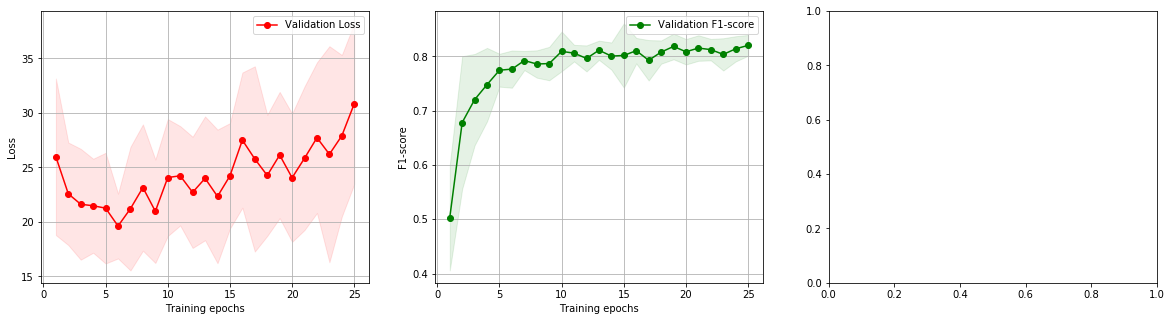

In [159]:
_, axes = plt.subplots(1,3,figsize=(20, 5))
axes[0].set_xlabel("Training epochs")
axes[0].set_ylabel("Loss")

# Plot learning curve
axes[0].grid()
axes[0].fill_between(train_sizes, train_losses_mean - train_losses_std,
                     train_losses_mean + train_losses_std, alpha=0.1,
                     color="r")
axes[0].plot(train_sizes, train_losses_mean, 'o-', color="r",
             label="Validation Loss")
axes[0].legend(loc="best")
##########################################################################
axes[1].set_xlabel("Training epochs")
axes[1].set_ylabel("F1-score")

# Plot learning curve
axes[1].grid()
axes[1].fill_between(train_sizes, train_f1_mean - train_f1_std,
                     train_f1_mean + train_f1_std, alpha=0.1,
                     color="g")
axes[1].plot(train_sizes, train_f1_mean, 'o-', color="g",
             label="Validation F1-score")
axes[1].legend(loc="best")

### Save best model

In [79]:
BEST_MODEL_RECORDS

[{'iter': 0, 'macro_avg': 0.6585991713693428},
 {'iter': 1, 'macro_avg': 0.7517082081030869},
 {'iter': 2, 'macro_avg': 0.7305036753424899},
 {'iter': 3, 'macro_avg': 0.6902004741461556},
 {'iter': 4, 'macro_avg': 0.7440229999359618}]

In [117]:
model.set_weights(best_model_weights)

In [107]:
checkpoint_path = "training_best/cp-best.ckpt"

In [118]:
model.save_weights(checkpoint_path)

### Load best

In [121]:
model, loss_fn = get_custom_emb_model()

In [122]:
model.load_weights(checkpoint_path)

In [123]:
reports = evaluate_model(model)

Testing language:  en
pages: 49  domains: 34
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.860465   0.571429    0.780899    0.715947      0.806387
recall       0.880952   0.965517    0.896774    0.923235      0.896774
f1-score     0.870588   0.717949    0.834835    0.794268      0.842030
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE      NEXT   micro avg   macro avg  weighted avg
precision    0.884058   0.52381    0.800000    0.703934      0.834831
recall       0.877698   1.00000    0.894410    0.938849      0.894410
f1-score     0.880866   0.68750    0.844575    0.784183      0.854444
support    139.000000  22.00000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.783784  0.636364   0.750000   0.710074      0.760331
recall      0.783784  1.000000   0.818182   0.891892      0.818182
f1-score    0.783784  0.777778   0.782609   0.780781      0.782828
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.721116   0.461538    0.676568    0.591327      0.700418
recall       0.653430   1.000000    0.681063    0.826715      0.681063
f1-score     0.685606   0.631579    0.678808    0.658593      0.681298
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.893617   0.562500   0.809524   0.728059      0.832912
recall      0.857143   0.818182   0.850000   0.837662      0.850000
f1-score    0.875000   0.666667   0.829268   0.770833      0.836806
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.495798  0.416667   0.488550   0.456232      0.489711
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.659218  0.588235   0.653061   0.623727      0.653758
support    60.000000  5.000000  65.000000  65.000000     65.000000


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [124]:
macro_avg = calculate_macro_avg(reports)

In [125]:
print(macro_avg)

0.7353974822209121


### Heuristic label

In [ ]:
HUE_EXP_RECORDS = []
for iteration in range(3):
    print("Iteration start ",iteration)
    model, loss_fn = get_ablation_model_hl(use_crf=True)
    model, avg_epoch_result = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    reports = evaluate_model(model)
    macro_avg = calculate_macro_avg(reports)
    print(f"Iter: {iteration}, macro f1: {macro_avg}")
    record = {"iter": iteration, "macro_avg": macro_avg}
    HUE_EXP_RECORDS.append(record)

Iteration start  0

Start of epoch 0
Validation loss: 25.8569
Validation F1: 0.4722
Time taken: 77.60s

Start of epoch 1
Validation loss: 24.1039
Validation F1: 0.6784
Time taken: 75.68s

Start of epoch 2
Validation loss: 25.8279
Validation F1: 0.6993
Time taken: 76.77s

Start of epoch 3
Validation loss: 26.8565
Validation F1: 0.5213
Time taken: 76.56s

Start of epoch 4
Validation loss: 16.4709
Validation F1: 0.7902
Time taken: 78.01s

Start of epoch 5
Validation loss: 21.8938
Validation F1: 0.7945
Time taken: 76.71s

Start of epoch 6
Validation loss: 17.7519
Validation F1: 0.7236
Time taken: 77.74s

Start of epoch 7
Validation loss: 19.1178
Validation F1: 0.7978
Time taken: 76.82s

Start of epoch 8
Validation loss: 24.2398
Validation F1: 0.8313
Time taken: 76.34s

Start of epoch 9
Validation loss: 16.9351
Validation F1: 0.8399
Time taken: 76.28s

Start of epoch 10
Validation loss: 24.3342
Validation F1: 0.8304
Time taken: 77.09s

Start of epoch 11
Validation loss: 30.8482
Validation F

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.813433   0.738095    0.795455    0.775764      0.795472
recall       0.947826   0.861111    0.927152    0.904469      0.927152
f1-score     0.875502   0.794872    0.856269    0.835187      0.856279
support    115.000000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.920635   0.894737    0.914634    0.907686      0.914990
recall       0.950820   1.000000    0.961538    0.975410      0.961538
f1-score     0.935484   0.944444    0.937500    0.939964      0.937437
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   0.888889   0.804348   0.836336      0.814546
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.878788   0.761905   0.850575   0.820346      0.844578
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.672932    0.575000    0.660131    0.623966      0.635215
recall       0.983516    0.201754    0.682432    0.592635      0.682432
f1-score     0.799107    0.298701    0.671096    0.548904      0.606383
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.581395   0.866667   0.655172   0.724031      0.655172
recall      0.581395   0.866667   0.655172   0.724031      0.655172
f1-score    0.581395   0.866667   0.655172   0.724031      0.655172
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.518182  0.500000   0.517241   0.509091      0.516783
recall      0.950000  0.600000   0.923077   0.775000      0.923077
f1-score    0.670588  0.545455   0.662983   0.608021      0.660963
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7460756664016444
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 22.7777
Validation F1: 0.5144
Time taken: 75.53s

Start of epoch 1
Validation loss: 26.5685
Validation F1: 0.5129
Time taken: 75.89s

Start of epoch 2
Validation loss: 20.5347
Validation F1: 0.7221
Time taken: 74.78s

Start of epoch 3
Validation loss: 16.5090
Validation F1: 0.7029
Time taken: 75.53s

Start of epoch 4
Validation loss: 20.4820
Validation F1: 0.7674
Time taken: 75.06s

Start of epoch 5
Validation loss: 29.5926
Validation F1: 0.7670
Time taken: 75.61s

Start of epoch 6
Validation loss: 19.1237
Validation F1: 0.7638
Time taken: 76.08s

Start of epoch 7
Validation loss: 25.9378
Validation F1: 0.7673
Time taken: 76.39s

Start of epoch 8
Validation loss: 24.5153
Validation F1: 0.7867
Time taken: 77.29s

Start of epoch 9
Validation loss: 25.4339
Validation F1: 0.7862
Time taken: 75.28s

Start of epoch 10
Validation loss: 22.0384
Validation F1: 0.7952
Time taken: 97.83s

Start of epoch 11
Validation loss: 28.5426
Validation F1: 0.8613
Time taken: 76.09s

Start o

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.80597   0.702128    0.779006    0.754049      0.781213
recall       0.93913   0.916667    0.933775    0.927899      0.933775
f1-score     0.86747   0.795181    0.849398    0.831325      0.850235
support    115.00000  36.000000  151.000000  151.000000    151.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.884058   0.894737    0.886364    0.889397      0.886385
recall       1.000000   1.000000    1.000000    1.000000      1.000000
f1-score     0.938462   0.944444    0.939759    0.941453      0.939766
support    122.000000  34.000000  156.000000  156.000000    156.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.783784   0.888889   0.804348   0.836336      0.814546
recall      1.000000   0.666667   0.902439   0.833333      0.902439
f1-score    0.878788   0.761905   0.850575   0.820346      0.844578
support    29.000000  12.000000  41.000000  41.000000     41.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE        NEXT   micro avg   macro avg  weighted avg
precision    0.560000    0.575000    0.561644    0.567500      0.565777
recall       1.000000    0.201754    0.692568    0.600877      0.692568
f1-score     0.717949    0.298701    0.620272    0.508325      0.556482
support    182.000000  114.000000  296.000000  296.000000    296.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.574468   0.684211   0.606061   0.629339      0.602850
recall      0.627907   0.866667   0.689655   0.747287      0.689655
f1-score    0.600000   0.764706   0.645161   0.682353      0.642596
support    43.000000  15.000000  58.000000  58.000000     58.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.627660  0.500000   0.622449   0.563830      0.617840
recall      0.983333  0.400000   0.938462   0.691667      0.938462
f1-score    0.766234  0.444444   0.748466   0.605339      0.741481
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7315236113074525
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 16.2272
Validation F1: 0.4866
Time taken: 76.89s

Start of epoch 1
Validation loss: 16.4632
Validation F1: 0.6963
Time taken: 76.38s

Start of epoch 2
Validation loss: 18.6148
Validation F1: 0.6136
Time taken: 75.15s

Start of epoch 3
Validation loss: 16.8318
Validation F1: 0.7932
Time taken: 76.20s

Start of epoch 4
Validation loss: 16.7315
Validation F1: 0.7466
Time taken: 76.39s

Start of epoch 5


### EMB Exp

In [205]:
EMB_EXP_RECORDS = []

In [206]:
for EMB_SIZE in [16,32,64,128]:
    for iteration in range(5):
        print("Iteration start ",iteration)
        model, loss_fn = get_custom_emb_model(use_crf=True, embedding_size = EMB_SIZE, hidden_size = 300)
        model, best = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
        print("best: ",best)
        reports = evaluate_model(model)
        macro_avg = calculate_macro_avg(reports)
        print(f"Iter: {iteration}, macro f1: {macro_avg}")
        record = {"EMB_SIZE": EMB_SIZE, "iter": iteration, "macro_avg": macro_avg}
        EMB_EXP_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 34.3138
Validation F1: 0.6014
Time taken: 113.39s

Start of epoch 1
Validation loss: 17.0073
Validation F1: 0.7074
Time taken: 113.20s

Start of epoch 2
Validation loss: 18.7226
Validation F1: 0.7819
Time taken: 112.43s

Start of epoch 3
Validation loss: 14.6766
Validation F1: 0.7792
Time taken: 112.22s

Start of epoch 4
Validation loss: 12.0428
Validation F1: 0.8029
Time taken: 112.59s

Start of epoch 5
Validation loss: 11.4528
Validation F1: 0.8085
Time taken: 112.39s

Start of epoch 6
Validation loss: 16.1938
Validation F1: 0.8333
Time taken: 113.17s

Start of epoch 7
Validation loss: 11.6281
Validation F1: 0.8235
Time taken: 112.25s

Start of epoch 8
Validation loss: 12.3682
Validation F1: 0.8156
Time taken: 113.87s

Start of epoch 9
Validation loss: 19.5932
Validation F1: 0.8152
Time taken: 113.02s

Start of epoch 10
Validation loss: 15.3122
Validation F1: 0.8273
Time taken: 112.14s

Start of epoch 11
Validation loss: 13.6606
Validation F1: 0.8073
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.836879   0.609756    0.785714    0.723318      0.794385
recall       0.936508   0.862069    0.922581    0.899288      0.922581
f1-score     0.883895   0.714286    0.848665    0.799090      0.852162
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.814371   0.833333    0.816754    0.823852      0.816962
recall       0.978417   0.909091    0.968944    0.943754      0.968944
f1-score     0.888889   0.869565    0.886364    0.879227      0.886248
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.789474  0.875000   0.804348   0.832237      0.803080
recall      0.810811  1.000000   0.840909   0.905405      0.840909
f1-score    0.800000  0.933333   0.822222   0.866667      0.821212
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.574468   0.709677    0.586111    0.642073      0.585249
recall       0.682310   0.916667    0.700997    0.799489      0.700997
f1-score     0.623762   0.800000    0.638427    0.711881      0.637815
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.551724   0.500000   0.539474   0.525862      0.542241
recall      0.653061   0.818182   0.683333   0.735622      0.683333
f1-score    0.598131   0.620690   0.602941   0.609410      0.602267
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.487603   0.2   0.476190   0.343802      0.465480
recall      0.983333   0.2   0.923077   0.591667      0.923077
f1-score    0.651934   0.2   0.628272   0.425967      0.617170
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7153737382645313
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 41.9915
Validation F1: 0.5461
Time taken: 112.56s

Start of epoch 1
Validation loss: 20.5056
Validation F1: 0.7211
Time taken: 113.43s

Start of epoch 2
Validation loss: 21.2944
Validation F1: 0.7529
Time taken: 112.96s

Start of epoch 3
Validation loss: 20.9387
Validation F1: 0.7927
Time taken: 112.63s

Start of epoch 4
Validation loss: 16.9190
Validation F1: 0.7474
Time taken: 112.48s

Start of epoch 5
Validation loss: 21.3432
Validation F1: 0.8020
Time taken: 112.65s

Start of epoch 6
Validation loss: 23.9618
Validation F1: 0.8185
Time taken: 113.95s

Start of epoch 7
Validation loss: 17.9354
Validation F1: 0.7963
Time taken: 111.52s

Start of epoch 8
Validation loss: 17.4340
Validation F1: 0.7797
Time taken: 113.17s

Start of epoch 9
Validation loss: 24.6745
Validation F1: 0.8323
Time taken: 112.27s

Start of epoch 10
Validation loss: 26.5147
Validation F1: 0.8313
Time taken: 113.43s

Start of epoch 11
Validation loss: 17.1107
Validation F1: 0.7838
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.859259   0.787879    0.845238    0.823569      0.845904
recall       0.920635   0.896552    0.916129    0.908593      0.916129
f1-score     0.888889   0.838710    0.879257    0.863799      0.879501
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.880000   0.952381    0.888889    0.916190      0.889891
recall       0.949640   0.909091    0.944099    0.929366      0.944099
f1-score     0.913495   0.930233    0.915663    0.921864      0.915782
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.777778  0.875000   0.795455   0.826389      0.793245
recall      0.756757  1.000000   0.795455   0.878378      0.795455
f1-score    0.767123  0.933333   0.795455   0.850228      0.793566
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.669118   0.826087    0.681356    0.747602      0.681633
recall       0.657040   0.791667    0.667774    0.724353      0.667774
f1-score     0.663024   0.808511    0.674497    0.735767      0.674624
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.620000   0.692308   0.634921   0.656154      0.633256
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.626263   0.750000   0.650407   0.688131      0.648948
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.634409   0.0   0.627660   0.317204      0.585608
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.771242   0.0   0.742138   0.385621      0.711916
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7409017774319923
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 14.9393
Validation F1: 0.5321
Time taken: 114.71s

Start of epoch 1
Validation loss: 19.7432
Validation F1: 0.7639
Time taken: 113.28s

Start of epoch 2
Validation loss: 15.2431
Validation F1: 0.7819
Time taken: 113.64s

Start of epoch 3
Validation loss: 11.9551
Validation F1: 0.7779
Time taken: 113.06s

Start of epoch 4
Validation loss: 12.8399
Validation F1: 0.7832
Time taken: 113.82s

Start of epoch 5
Validation loss: 12.7426
Validation F1: 0.7832
Time taken: 113.86s

Start of epoch 6
Validation loss: 10.2619
Validation F1: 0.7731
Time taken: 112.49s

Start of epoch 7
Validation loss: 11.7758
Validation F1: 0.8098
Time taken: 113.10s

Start of epoch 8
Validation loss: 10.8920
Validation F1: 0.7988
Time taken: 113.74s

Start of epoch 9
Validation loss: 15.2823
Validation F1: 0.8108
Time taken: 111.85s

Start of epoch 10
Validation loss: 15.3471
Validation F1: 0.8119
Time taken: 113.17s

Start of epoch 11
Validation loss: 12.3255
Validation F1: 0.8120
Time taken: 112.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.866667   0.735294    0.840237    0.800980      0.842087
recall       0.928571   0.862069    0.916129    0.895320      0.916129
f1-score     0.896552   0.793651    0.876543    0.845101      0.877299
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.868056   0.809524    0.860606    0.838790      0.860057
recall       0.899281   0.772727    0.881988    0.836004      0.881988
f1-score     0.883392   0.790698    0.871166    0.837045      0.870726
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.800000   1.0   0.829787   0.900000      0.831818
recall      0.864865   1.0   0.886364   0.932432      0.886364
f1-score    0.831169   1.0   0.857143   0.915584      0.858028
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.687023   0.809524    0.696113    0.748273      0.696790
recall       0.649819   0.708333    0.654485    0.679076      0.654485
f1-score     0.667904   0.755556    0.674658    0.711730      0.674892
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.565217   0.700000   0.589286   0.632609      0.589928
recall      0.530612   0.636364   0.550000   0.583488      0.550000
f1-score    0.547368   0.666667   0.568966   0.607018      0.569240
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.655556  0.666667   0.655914   0.661111      0.656410
recall      0.983333  0.400000   0.938462   0.691667      0.938462
f1-score    0.786667  0.500000   0.772152   0.643333      0.764615
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7599685070427061
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 29.5819
Validation F1: 0.4365
Time taken: 114.42s

Start of epoch 1
Validation loss: 22.9864
Validation F1: 0.6623
Time taken: 113.80s

Start of epoch 2
Validation loss: 25.3617
Validation F1: 0.6513
Time taken: 113.68s

Start of epoch 3
Validation loss: 29.0803
Validation F1: 0.7101
Time taken: 113.83s

Start of epoch 4
Validation loss: 21.2814
Validation F1: 0.6756
Time taken: 114.05s

Start of epoch 5
Validation loss: 21.7969
Validation F1: 0.6862
Time taken: 114.26s

Start of epoch 6
Validation loss: 20.4200
Validation F1: 0.8022
Time taken: 113.04s

Start of epoch 7
Validation loss: 24.2798
Validation F1: 0.8072
Time taken: 113.19s

Start of epoch 8
Validation loss: 24.1208
Validation F1: 0.7980
Time taken: 112.88s

Start of epoch 9
Validation loss: 21.0371
Validation F1: 0.7974
Time taken: 113.90s

Start of epoch 10
Validation loss: 22.0700
Validation F1: 0.8066
Time taken: 112.83s

Start of epoch 11
Validation loss: 38.6688
Validation F1: 0.8533
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.728395   0.658537    0.714286    0.693466      0.715325
recall       0.936508   0.931034    0.935484    0.933771      0.935484
f1-score     0.819444   0.771429    0.810056    0.795437      0.810461
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.790419   0.647059    0.766169    0.718739      0.770830
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.862745   0.785714    0.850829    0.824230      0.852219
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.538905   0.512821    0.536269    0.525863      0.536825
recall       0.675090   0.833333    0.687708    0.754212      0.687708
f1-score     0.599359   0.634921    0.602620    0.617140      0.602194
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.424658   0.538462   0.441860   0.481560      0.445522
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.508197   0.583333   0.520548   0.545765      0.521972
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.299492   0.6   0.306931   0.449746      0.322608
recall      0.983333   0.6   0.953846   0.791667      0.953846
f1-score    0.459144   0.6   0.464419   0.529572      0.469979
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7020238360352109
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 31.3142
Validation F1: 0.5207
Time taken: 113.03s

Start of epoch 1
Validation loss: 24.7984
Validation F1: 0.5132
Time taken: 113.62s

Start of epoch 2
Validation loss: 26.2881
Validation F1: 0.6492
Time taken: 112.03s

Start of epoch 3
Validation loss: 25.5738
Validation F1: 0.7640
Time taken: 112.03s

Start of epoch 4
Validation loss: 22.3657
Validation F1: 0.7188
Time taken: 113.30s

Start of epoch 5
Validation loss: 26.2512
Validation F1: 0.7653
Time taken: 110.71s

Start of epoch 6
Validation loss: 35.2315
Validation F1: 0.7711
Time taken: 113.10s

Start of epoch 7
Validation loss: 29.1387
Validation F1: 0.7310
Time taken: 111.74s

Start of epoch 8
Validation loss: 31.3211
Validation F1: 0.7700
Time taken: 111.61s

Start of epoch 9
Validation loss: 28.6521
Validation F1: 0.7800
Time taken: 113.25s

Start of epoch 10
Validation loss: 29.5296
Validation F1: 0.7762
Time taken: 112.76s

Start of epoch 11
Validation loss: 29.4873
Validation F1: 0.7650
Time taken: 112.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.923729   0.655172    0.870748    0.789451      0.873483
recall       0.865079   0.655172    0.825806    0.760126      0.825806
f1-score     0.893443   0.655172    0.847682    0.774308      0.848863
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.900000   0.625000    0.867647    0.762500      0.862422
recall       0.776978   0.454545    0.732919    0.615762      0.732919
f1-score     0.833977   0.526316    0.794613    0.680146      0.791936
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.764706  1.000000   0.800000   0.882353      0.802139
recall      0.702703  0.857143   0.727273   0.779923      0.727273
f1-score    0.732394  0.923077   0.761905   0.827736      0.762730
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.792079   0.666667    0.780269    0.729373      0.782080
recall       0.577617   0.583333    0.578073    0.580475      0.578073
f1-score     0.668058   0.622222    0.664122    0.645140      0.664404
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.894737   0.600000   0.793103   0.747368      0.840702
recall      0.346939   0.545455   0.383333   0.446197      0.383333
f1-score    0.500000   0.571429   0.516854   0.535714      0.513095
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.736842   0.0   0.736842   0.368421      0.680162
recall      0.700000   0.0   0.646154   0.350000      0.646154
f1-score    0.717949   0.0   0.688525   0.358974      0.662722
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.6370030763485734
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 26.7288
Validation F1: 0.6274
Time taken: 113.75s

Start of epoch 1
Validation loss: 23.3427
Validation F1: 0.7573
Time taken: 114.70s

Start of epoch 2
Validation loss: 21.6555
Validation F1: 0.6455
Time taken: 114.36s

Start of epoch 3
Validation loss: 22.1457
Validation F1: 0.7715
Time taken: 114.23s

Start of epoch 4
Validation loss: 24.0583
Validation F1: 0.7029
Time taken: 113.46s

Start of epoch 5
Validation loss: 26.8977
Validation F1: 0.7937
Time taken: 114.20s

Start of epoch 6
Validation loss: 31.9586
Validation F1: 0.7916
Time taken: 114.61s

Start of epoch 7
Validation loss: 30.3154
Validation F1: 0.8020
Time taken: 114.53s

Start of epoch 8
Validation loss: 26.3419
Validation F1: 0.6480
Time taken: 113.32s

Start of epoch 9
Validation loss: 29.5300
Validation F1: 0.8004
Time taken: 113.85s

Start of epoch 10
Validation loss: 31.1912
Validation F1: 0.8180
Time taken: 114.47s

Start of epoch 11
Validation loss: 25.6079
Validation F1: 0.7986
Time taken: 115.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.739130   0.710526    0.733668    0.724828      0.733779
recall       0.944444   0.931034    0.941935    0.937739      0.941935
f1-score     0.829268   0.805970    0.824859    0.817619      0.824909
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.786127   0.645161    0.764706    0.715644      0.766865
recall       0.978417   0.909091    0.968944    0.943754      0.968944
f1-score     0.871795   0.754717    0.854795    0.813256      0.855797
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  0.700000   0.780000   0.750000      0.784091
recall      0.864865  1.000000   0.886364   0.932432      0.886364
f1-score    0.831169  0.823529   0.829787   0.827349      0.829953
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.546243   0.628571    0.553806    0.587407      0.552807
recall       0.682310   0.916667    0.700997    0.799489      0.700997
f1-score     0.606742   0.745763    0.618768    0.676252      0.617826
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.534483   0.750000   0.571429   0.642241      0.573994
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.579439   0.782609   0.615385   0.681024      0.616687
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.359756  0.625000   0.372093   0.492378      0.380159
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.526786  0.769231   0.540084   0.648008      0.545435
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7439181045166969
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 25.2637
Validation F1: 0.4727
Time taken: 115.85s

Start of epoch 1
Validation loss: 22.2530
Validation F1: 0.5108
Time taken: 113.47s

Start of epoch 2
Validation loss: 23.9783
Validation F1: 0.5476
Time taken: 114.67s

Start of epoch 3
Validation loss: 22.5076
Validation F1: 0.7043
Time taken: 115.78s

Start of epoch 4
Validation loss: 19.0004
Validation F1: 0.7016
Time taken: 115.11s

Start of epoch 5
Validation loss: 17.8667
Validation F1: 0.7111
Time taken: 115.17s

Start of epoch 6
Validation loss: 24.6874
Validation F1: 0.7899
Time taken: 115.59s

Start of epoch 7
Validation loss: 19.6736
Validation F1: 0.5933
Time taken: 113.98s

Start of epoch 8
Validation loss: 24.9012
Validation F1: 0.7839
Time taken: 113.98s

Start of epoch 9
Validation loss: 27.8749
Validation F1: 0.7789
Time taken: 113.76s

Start of epoch 10
Validation loss: 28.2012
Validation F1: 0.7840
Time taken: 115.46s

Start of epoch 11
Validation loss: 31.3107
Validation F1: 0.7877
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.723270   0.619048    0.701493    0.671159      0.703771
recall       0.912698   0.896552    0.909677    0.904625      0.909677
f1-score     0.807018   0.732394    0.792135    0.769706      0.793056
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.786127   0.666667    0.768473    0.726397      0.769803
recall       0.978417   0.909091    0.968944    0.943754      0.968944
f1-score     0.871795   0.769231    0.857143    0.820513      0.857780
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.541547   0.636364    0.549738    0.588955      0.549107
recall       0.682310   0.875000    0.697674    0.778655      0.697674
f1-score     0.603834   0.736842    0.614934    0.670338      0.614439
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.460674   0.529412   0.471698   0.495043      0.473276
recall      0.836735   0.818182   0.833333   0.827458      0.833333
f1-score    0.594203   0.642857   0.602410   0.618530      0.603123
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.293532  0.714286   0.307692   0.503909      0.325898
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.452107  0.833333   0.468864   0.642720      0.481432
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7369678480495846
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 40.5615
Validation F1: 0.5202
Time taken: 114.44s

Start of epoch 1
Validation loss: 31.4783
Validation F1: 0.7512
Time taken: 113.79s

Start of epoch 2
Validation loss: 26.1592
Validation F1: 0.7781
Time taken: 114.98s

Start of epoch 3
Validation loss: 18.4628
Validation F1: 0.6309
Time taken: 115.07s

Start of epoch 4
Validation loss: 24.2429
Validation F1: 0.7929
Time taken: 116.30s

Start of epoch 5
Validation loss: 23.4614
Validation F1: 0.7894
Time taken: 114.24s

Start of epoch 6
Validation loss: 29.2888
Validation F1: 0.8032
Time taken: 113.21s

Start of epoch 7
Validation loss: 28.7024
Validation F1: 0.7718
Time taken: 115.53s

Start of epoch 8
Validation loss: 25.6989
Validation F1: 0.8081
Time taken: 114.50s

Start of epoch 9
Validation loss: 34.4690
Validation F1: 0.8017
Time taken: 114.28s

Start of epoch 10
Validation loss: 20.1268
Validation F1: 0.7848
Time taken: 114.14s

Start of epoch 11
Validation loss: 43.0259
Validation F1: 0.8429
Time taken: 114.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.605128   0.666667    0.615385    0.635897      0.616642
recall       0.936508   0.896552    0.929032    0.916530      0.929032
f1-score     0.735202   0.764706    0.740360    0.749954      0.740722
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.781609   0.740741    0.776119    0.761175      0.776025
recall       0.978417   0.909091    0.968944    0.943754      0.968944
f1-score     0.869010   0.816327    0.861878    0.842668      0.861811
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.809524   1.0   0.836735   0.904762      0.839827
recall      0.918919   1.0   0.931818   0.959459      0.931818
f1-score    0.860759   1.0   0.881720   0.930380      0.882911
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.552326   0.740741    0.566038    0.646533      0.567349
recall       0.685921   0.833333    0.697674    0.759627      0.697674
f1-score     0.611916   0.784314    0.625000    0.698115      0.625662
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.461538   0.900000   0.500000   0.680769      0.541923
recall      0.979592   0.818182   0.950000   0.898887      0.950000
f1-score    0.627451   0.857143   0.655172   0.742297      0.669561
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.380645  0.714286   0.395062   0.547465      0.406310
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.548837  0.833333   0.563877   0.691085      0.570722
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7757498627719578
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 39.2490
Validation F1: 0.4978
Time taken: 115.72s

Start of epoch 1
Validation loss: 22.9457
Validation F1: 0.7280
Time taken: 113.76s

Start of epoch 2
Validation loss: 25.9167
Validation F1: 0.7097
Time taken: 114.07s

Start of epoch 3
Validation loss: 23.7553
Validation F1: 0.7609
Time taken: 113.91s

Start of epoch 4
Validation loss: 18.4354
Validation F1: 0.7204
Time taken: 112.81s

Start of epoch 5
Validation loss: 24.4447
Validation F1: 0.7868
Time taken: 113.16s

Start of epoch 6
Validation loss: 20.2207
Validation F1: 0.8075
Time taken: 114.71s

Start of epoch 7
Validation loss: 24.7840
Validation F1: 0.7947
Time taken: 113.58s

Start of epoch 8
Validation loss: 29.7713
Validation F1: 0.8087
Time taken: 113.86s

Start of epoch 9
Validation loss: 30.3370
Validation F1: 0.8436
Time taken: 114.12s

Start of epoch 10
Validation loss: 31.5228
Validation F1: 0.8183
Time taken: 114.52s

Start of epoch 11
Validation loss: 24.1601
Validation F1: 0.8286
Time taken: 114.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.838028   0.666667    0.798913    0.752347      0.805967
recall       0.944444   0.965517    0.948387    0.954981      0.948387
f1-score     0.888060   0.788732    0.867257    0.838396      0.869476
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.857143   0.758621    0.841530    0.807882      0.843680
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.901024   0.862745    0.895349    0.881884      0.895793
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.783784  0.777778   0.782609   0.780781      0.782828
recall      0.783784  1.000000   0.818182   0.891892      0.818182
f1-score    0.783784  0.875000   0.800000   0.829392      0.798295
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.595395   0.733333    0.607784    0.664364      0.606393
recall       0.653430   0.916667    0.674419    0.785048      0.674419
f1-score     0.623064   0.814815    0.639370    0.718939      0.638353
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.596154   0.562500   0.588235   0.579327      0.589984
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.613861   0.666667   0.625000   0.640264      0.623542
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.531532  0.714286   0.542373   0.622909      0.545590
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.690058  0.833333   0.699454   0.761696      0.701080
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7784286026880797
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 25.1736
Validation F1: 0.5139
Time taken: 114.79s

Start of epoch 1
Validation loss: 24.5491
Validation F1: 0.7208
Time taken: 114.32s

Start of epoch 2
Validation loss: 27.5773
Validation F1: 0.7881
Time taken: 115.12s

Start of epoch 3
Validation loss: 18.3055
Validation F1: 0.7752
Time taken: 114.01s

Start of epoch 4
Validation loss: 21.9938
Validation F1: 0.7515
Time taken: 113.41s

Start of epoch 5
Validation loss: 25.3897
Validation F1: 0.8187
Time taken: 113.47s

Start of epoch 6
Validation loss: 22.3974
Validation F1: 0.8214
Time taken: 114.56s

Start of epoch 7
Validation loss: 24.1752
Validation F1: 0.8272
Time taken: 114.01s

Start of epoch 8
Validation loss: 25.3139
Validation F1: 0.8236
Time taken: 113.43s

Start of epoch 9
Validation loss: 30.0759
Validation F1: 0.8267
Time taken: 114.64s

Start of epoch 10
Validation loss: 19.4436
Validation F1: 0.6416
Time taken: 113.36s

Start of epoch 11
Validation loss: 28.6086
Validation F1: 0.8291
Time taken: 113.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.867647   0.800000    0.853801    0.833824      0.854991
recall       0.936508   0.965517    0.941935    0.951013      0.941935
f1-score     0.900763   0.875000    0.895706    0.887882      0.895943
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.928058   0.916667    0.926380    0.922362      0.926501
recall       0.928058   1.000000    0.937888    0.964029      0.937888
f1-score     0.928058   0.956522    0.932099    0.942290      0.931947
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.708171   0.692308    0.706714    0.700239      0.706906
recall       0.657040   0.750000    0.664452    0.703520      0.664452
f1-score     0.681648   0.720000    0.684932    0.700824      0.684706
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.966667   1.000000   0.974359   0.983333      0.972778
recall      0.591837   0.818182   0.633333   0.705009      0.633333
f1-score    0.734177   0.900000   0.767677   0.817089      0.764578
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.475410  0.500000   0.475806   0.487705      0.477301
recall      0.966667  0.200000   0.907692   0.583333      0.907692
f1-score    0.637363  0.285714   0.624339   0.461538      0.610313
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7849370608506332
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 22.1362
Validation F1: 0.5400
Time taken: 121.54s

Start of epoch 1
Validation loss: 23.2266
Validation F1: 0.5723
Time taken: 118.39s

Start of epoch 2
Validation loss: 17.4124
Validation F1: 0.7918
Time taken: 118.54s

Start of epoch 3
Validation loss: 26.4393
Validation F1: 0.7881
Time taken: 118.35s

Start of epoch 4
Validation loss: 23.7853
Validation F1: 0.7458
Time taken: 117.52s

Start of epoch 5
Validation loss: 20.7101
Validation F1: 0.8071
Time taken: 118.40s

Start of epoch 6
Validation loss: 19.3399
Validation F1: 0.8087
Time taken: 118.58s

Start of epoch 7
Validation loss: 23.8293
Validation F1: 0.8020
Time taken: 119.31s

Start of epoch 8
Validation loss: 27.1576
Validation F1: 0.8018
Time taken: 119.18s

Start of epoch 9
Validation loss: 27.6456
Validation F1: 0.8020
Time taken: 118.49s

Start of epoch 10
Validation loss: 21.9836
Validation F1: 0.7787
Time taken: 118.55s

Start of epoch 11
Validation loss: 25.8987
Validation F1: 0.8055
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.871212   0.666667    0.824561    0.768939      0.832942
recall       0.912698   0.896552    0.909677    0.904625      0.909677
f1-score     0.891473   0.764706    0.865031    0.828089      0.867755
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE      NEXT   micro avg   macro avg  weighted avg
precision    0.935252   0.88000    0.926829    0.907626      0.927702
recall       0.935252   1.00000    0.944099    0.967626      0.944099
f1-score     0.935252   0.93617    0.935385    0.935711      0.935377
support    139.000000  22.00000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.800000   1.0   0.829787   0.900000      0.831818
recall      0.864865   1.0   0.886364   0.932432      0.886364
f1-score    0.831169   1.0   0.857143   0.915584      0.858028
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.652482   0.863636    0.667763    0.758059      0.669318
recall       0.664260   0.791667    0.674419    0.727963      0.674419
f1-score     0.658318   0.826087    0.671074    0.742203      0.671695
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.638298   0.750000   0.654545   0.694149      0.658777
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.625000   0.631579   0.626087   0.628289      0.626206
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.406897  0.714286   0.421053   0.560591      0.430542
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.575610  0.833333   0.589862   0.704472      0.595435
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7923914176789396
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 33.0223
Validation F1: 0.5146
Time taken: 119.85s

Start of epoch 1
Validation loss: 26.2940
Validation F1: 0.7182
Time taken: 120.32s

Start of epoch 2
Validation loss: 25.9291
Validation F1: 0.5861
Time taken: 119.19s

Start of epoch 3
Validation loss: 26.1180
Validation F1: 0.6253
Time taken: 119.23s

Start of epoch 4
Validation loss: 38.2995
Validation F1: 0.7732
Time taken: 117.95s

Start of epoch 5
Validation loss: 30.1225
Validation F1: 0.7955
Time taken: 119.14s

Start of epoch 6
Validation loss: 39.4241
Validation F1: 0.7866
Time taken: 118.42s

Start of epoch 7
Validation loss: 27.8530
Validation F1: 0.6718
Time taken: 118.71s

Start of epoch 8
Validation loss: 34.8608
Validation F1: 0.8012
Time taken: 118.23s

Start of epoch 9
Validation loss: 36.3484
Validation F1: 0.7929
Time taken: 119.58s

Start of epoch 10
Validation loss: 29.3465
Validation F1: 0.7268
Time taken: 117.83s

Start of epoch 11
Validation loss: 29.6025
Validation F1: 0.7478
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.847826   0.687500    0.817647    0.767663      0.817830
recall       0.928571   0.758621    0.896774    0.843596      0.896774
f1-score     0.886364   0.721311    0.855385    0.803838      0.855483
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.898551   0.916667    0.901235    0.907609      0.901026
recall       0.892086   1.000000    0.906832    0.946043      0.906832
f1-score     0.895307   0.956522    0.904025    0.925914      0.903672
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  1.000000   0.820513   0.900000      0.831818
recall      0.756757  0.571429   0.727273   0.664093      0.727273
f1-score    0.777778  0.727273   0.771084   0.752525      0.769743
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.635088   1.000000    0.656766    0.817544      0.664184
recall       0.653430   0.750000    0.661130    0.701715      0.661130
f1-score     0.644128   0.857143    0.658940    0.750635      0.661113
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.612245   0.857143   0.642857   0.734694      0.657143
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.612245   0.666667   0.620690   0.639456      0.622222
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.630435  1.000000   0.638298   0.815217      0.658863
recall      0.966667  0.400000   0.923077   0.683333      0.923077
f1-score    0.763158  0.571429   0.754717   0.667293      0.748409
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7566102680811095
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 27.3559
Validation F1: 0.5550
Time taken: 119.85s

Start of epoch 1
Validation loss: 29.3502
Validation F1: 0.7042
Time taken: 118.55s

Start of epoch 2
Validation loss: 27.3438
Validation F1: 0.7332
Time taken: 120.13s

Start of epoch 3
Validation loss: 17.7695
Validation F1: 0.8036
Time taken: 119.24s

Start of epoch 4
Validation loss: 18.3799
Validation F1: 0.7974
Time taken: 119.35s

Start of epoch 5
Validation loss: 33.2280
Validation F1: 0.8211
Time taken: 119.90s

Start of epoch 6
Validation loss: 19.5211
Validation F1: 0.7995
Time taken: 119.45s

Start of epoch 7
Validation loss: 25.8512
Validation F1: 0.8218
Time taken: 119.93s

Start of epoch 8
Validation loss: 25.2443
Validation F1: 0.8187
Time taken: 119.08s

Start of epoch 9
Validation loss: 21.6962
Validation F1: 0.8301
Time taken: 118.16s

Start of epoch 10
Validation loss: 30.5872
Validation F1: 0.8596
Time taken: 119.28s

Start of epoch 11
Validation loss: 22.7537
Validation F1: 0.8279
Time taken: 119.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.835714   0.702703    0.807910    0.769208      0.810828
recall       0.928571   0.896552    0.922581    0.912562      0.922581
f1-score     0.879699   0.787879    0.861446    0.833789      0.862520
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.895833   0.846154    0.888235    0.870994      0.889045
recall       0.928058   1.000000    0.937888    0.964029      0.937888
f1-score     0.911661   0.916667    0.912387    0.914164      0.912345
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.643836   0.714286    0.650000    0.679061      0.649453
recall       0.678700   0.833333    0.691030    0.756017      0.691030
f1-score     0.660808   0.769231    0.669887    0.715020      0.669453
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.620000   0.818182   0.655738   0.719091      0.656333
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.626263   0.818182   0.661157   0.722222      0.661448
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.460938  0.500000   0.461538   0.480469      0.463942
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.627660  0.285714   0.615385   0.456687      0.601356
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7569802491467393
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 21.8697
Validation F1: 0.5980
Time taken: 119.30s

Start of epoch 1
Validation loss: 17.2667
Validation F1: 0.7465
Time taken: 118.33s

Start of epoch 2
Validation loss: 21.0842
Validation F1: 0.7496
Time taken: 119.12s

Start of epoch 3
Validation loss: 18.0521
Validation F1: 0.7852
Time taken: 117.31s

Start of epoch 4
Validation loss: 21.9350
Validation F1: 0.7921
Time taken: 117.44s

Start of epoch 5
Validation loss: 20.4252
Validation F1: 0.7320
Time taken: 118.26s

Start of epoch 6
Validation loss: 20.4231
Validation F1: 0.7445
Time taken: 118.47s

Start of epoch 7
Validation loss: 27.4925
Validation F1: 0.7929
Time taken: 119.04s

Start of epoch 8
Validation loss: 25.2712
Validation F1: 0.7853
Time taken: 119.01s

Start of epoch 9
Validation loss: 25.8221
Validation F1: 0.8019
Time taken: 118.06s

Start of epoch 10
Validation loss: 28.1315
Validation F1: 0.8180
Time taken: 118.11s

Start of epoch 11
Validation loss: 24.5622
Validation F1: 0.8019
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.781457   0.657895    0.756614    0.719676      0.758339
recall       0.936508   0.862069    0.922581    0.899288      0.922581
f1-score     0.851986   0.746269    0.831395    0.799127      0.832206
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.809816   0.846154    0.814815    0.827985      0.814781
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.874172   0.916667    0.880000    0.895419      0.879979
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.777778   1.0   0.813953   0.888889      0.813131
recall      0.756757   1.0   0.795455   0.878378      0.795455
f1-score    0.767123   1.0   0.804598   0.883562      0.804172
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.570988   0.818182    0.586705    0.694585      0.590697
recall       0.667870   0.750000    0.674419    0.708935      0.674419
f1-score     0.615641   0.782609    0.627512    0.699125      0.628954
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.553571   0.583333   0.558824   0.568452      0.559028
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.590476   0.608696   0.593750   0.599586      0.593816
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.398649   0.0   0.395973   0.199324      0.367983
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.567308   0.0   0.551402   0.283654      0.523669
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.6934120988052667
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 22.7360
Validation F1: 0.4767
Time taken: 118.93s

Start of epoch 1
Validation loss: 21.4097
Validation F1: 0.5872
Time taken: 119.14s

Start of epoch 2
Validation loss: 23.8503
Validation F1: 0.7002
Time taken: 119.30s

Start of epoch 3
Validation loss: 29.4360
Validation F1: 0.7337
Time taken: 118.64s

Start of epoch 4
Validation loss: 22.5848
Validation F1: 0.8007
Time taken: 119.17s

Start of epoch 5
Validation loss: 21.3888
Validation F1: 0.6971
Time taken: 120.15s

Start of epoch 6
Validation loss: 23.9089
Validation F1: 0.7542
Time taken: 119.37s

Start of epoch 7
Validation loss: 25.2769
Validation F1: 0.7999
Time taken: 118.48s

Start of epoch 8
Validation loss: 22.2139
Validation F1: 0.7793
Time taken: 119.48s

Start of epoch 9
Validation loss: 22.1062
Validation F1: 0.8085
Time taken: 119.48s

Start of epoch 10
Validation loss: 26.5681
Validation F1: 0.8047
Time taken: 120.28s

Start of epoch 11
Validation loss: 24.6098
Validation F1: 0.6192
Time taken: 119.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.887218   0.729730    0.852941    0.808474      0.857752
recall       0.936508   0.931034    0.935484    0.933771      0.935484
f1-score     0.911197   0.818182    0.892308    0.864689      0.893794
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.897959   0.916667    0.900585    0.907313      0.900515
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.923077   0.956522    0.927711    0.939799      0.927647
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.783784   1.0   0.818182   0.891892      0.818182
recall      0.783784   1.0   0.818182   0.891892      0.818182
f1-score    0.783784   1.0   0.818182   0.891892      0.818182
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.629758   0.708333    0.635783    0.669046      0.636023
recall       0.657040   0.708333    0.661130    0.682687      0.661130
f1-score     0.643110   0.708333    0.648208    0.675721      0.648310
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.625000   0.636364   0.627119   0.630682      0.627083
recall      0.612245   0.636364   0.616667   0.624304      0.616667
f1-score    0.618557   0.636364   0.621849   0.627460      0.621821
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.641304  0.500000   0.638298   0.570652      0.630435
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.776316  0.285714   0.754717   0.531015      0.738577
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7550962051601484
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 19.6475
Validation F1: 0.5825
Time taken: 128.35s

Start of epoch 1
Validation loss: 13.6100
Validation F1: 0.4770
Time taken: 127.21s

Start of epoch 2
Validation loss: 14.4006
Validation F1: 0.7931
Time taken: 128.75s

Start of epoch 3
Validation loss: 16.3337
Validation F1: 0.8004
Time taken: 127.48s

Start of epoch 4
Validation loss: 19.0334
Validation F1: 0.7810
Time taken: 127.45s

Start of epoch 5
Validation loss: 14.1857
Validation F1: 0.7967
Time taken: 129.03s

Start of epoch 6
Validation loss: 12.6850
Validation F1: 0.8142
Time taken: 126.88s

Start of epoch 7
Validation loss: 12.0391
Validation F1: 0.8204
Time taken: 127.82s

Start of epoch 8
Validation loss: 17.4047
Validation F1: 0.8194
Time taken: 129.25s

Start of epoch 9
Validation loss: 23.7923
Validation F1: 0.8604
Time taken: 126.84s

Start of epoch 10
Validation loss: 22.4204
Validation F1: 0.8252
Time taken: 127.74s

Start of epoch 11
Validation loss: 24.1175
Validation F1: 0.8697
Time taken: 127.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.709091   0.444444    0.635965    0.576768      0.659576
recall       0.928571   0.965517    0.935484    0.947044      0.935484
f1-score     0.804124   0.608696    0.757180    0.706410      0.767560
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.830189   0.687500    0.806283    0.758844      0.810691
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.885906   0.814815    0.875000    0.850360      0.876192
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  1.000000   0.826087   0.900000      0.831818
recall      0.864865  0.857143   0.863636   0.861004      0.863636
f1-score    0.831169  0.923077   0.844444   0.877123      0.845791
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.658451   0.488889    0.635258    0.573670      0.644931
recall       0.675090   0.916667    0.694352    0.795878      0.694352
f1-score     0.666667   0.637681    0.663492    0.652174      0.664356
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.612245   0.750000   0.631579   0.681122      0.637500
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.612245   0.631579   0.615385   0.621912      0.615789
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.487603   0.8   0.500000   0.643802      0.511634
recall      0.983333   0.8   0.969231   0.891667      0.969231
f1-score    0.651934   0.8   0.659686   0.725967      0.663323
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7389909454929304
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 21.1488
Validation F1: 0.5512
Time taken: 127.76s

Start of epoch 1
Validation loss: 15.2366
Validation F1: 0.7241
Time taken: 128.13s

Start of epoch 2
Validation loss: 25.1824
Validation F1: 0.7890
Time taken: 126.88s

Start of epoch 3
Validation loss: 21.9397
Validation F1: 0.7883
Time taken: 127.38s

Start of epoch 4
Validation loss: 24.5449
Validation F1: 0.7891
Time taken: 128.43s

Start of epoch 5
Validation loss: 16.1608
Validation F1: 0.7904
Time taken: 127.86s

Start of epoch 6
Validation loss: 25.4631
Validation F1: 0.8224
Time taken: 127.13s

Start of epoch 7
Validation loss: 20.8528
Validation F1: 0.8094
Time taken: 127.70s

Start of epoch 8
Validation loss: 34.6835
Validation F1: 0.8688
Time taken: 127.89s

Start of epoch 9
Validation loss: 23.4675
Validation F1: 0.8315
Time taken: 127.80s

Start of epoch 10
Validation loss: 13.2638
Validation F1: 0.8110
Time taken: 127.72s

Start of epoch 11
Validation loss: 28.6159
Validation F1: 0.8688
Time taken: 127.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.839416   0.615385    0.789773    0.727400      0.797500
recall       0.912698   0.827586    0.896774    0.870142      0.896774
f1-score     0.874525   0.705882    0.839879    0.790204      0.842972
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE      NEXT   micro avg   macro avg  weighted avg
precision    0.820513   0.88000    0.828729    0.850256      0.828642
recall       0.920863   1.00000    0.931677    0.960432      0.931677
f1-score     0.867797   0.93617    0.877193    0.901983      0.877140
support    139.000000  22.00000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  0.777778   0.795918   0.788889      0.796465
recall      0.864865  1.000000   0.886364   0.932432      0.886364
f1-score    0.831169  0.875000   0.838710   0.853084      0.838142
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.740891   0.761905    0.742537    0.751398      0.742566
recall       0.660650   0.666667    0.661130    0.663658      0.661130
f1-score     0.698473   0.711111    0.699473    0.704792      0.699481
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.857143   0.969697   0.928571      0.973810
recall      0.530612   0.545455   0.533333   0.538033      0.533333
f1-score    0.693333   0.666667   0.688172   0.680000      0.688444
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.475806  0.500000   0.476190   0.487903      0.477667
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.641304  0.285714   0.628272   0.463509      0.613951
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.7322621457473821
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 19.3576
Validation F1: 0.5336
Time taken: 128.80s

Start of epoch 1
Validation loss: 15.7898
Validation F1: 0.6610
Time taken: 128.34s

Start of epoch 2
Validation loss: 25.7105
Validation F1: 0.7627
Time taken: 128.44s

Start of epoch 3
Validation loss: 56.2397
Validation F1: 0.6248
Time taken: 128.94s

Start of epoch 4
Validation loss: 22.5409
Validation F1: 0.7599
Time taken: 129.67s

Start of epoch 5
Validation loss: 18.8194
Validation F1: 0.7677
Time taken: 128.72s

Start of epoch 6
Validation loss: 25.3477
Validation F1: 0.7582
Time taken: 128.24s

Start of epoch 7
Validation loss: 21.0017
Validation F1: 0.5666
Time taken: 128.49s

Start of epoch 8
Validation loss: 17.7518
Validation F1: 0.7548
Time taken: 128.40s

Start of epoch 9
Validation loss: 20.9238
Validation F1: 0.7885
Time taken: 129.36s

Start of epoch 10
Validation loss: 26.1878
Validation F1: 0.7784
Time taken: 128.98s

Start of epoch 11
Validation loss: 24.8025
Validation F1: 0.8039
Time taken: 128.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.841727   0.638889    0.800000    0.740308      0.803776
recall       0.928571   0.793103    0.903226    0.860837      0.903226
f1-score     0.883019   0.707692    0.848485    0.795356      0.850216
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.810458   0.678571    0.790055    0.744514      0.792436
recall       0.892086   0.863636    0.888199    0.877861      0.888199
f1-score     0.849315   0.760000    0.836257    0.804658      0.837111
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.624585   0.740741    0.634146    0.682663      0.633846
recall       0.678700   0.833333    0.691030    0.756017      0.691030
f1-score     0.650519   0.784314    0.661367    0.717416      0.661187
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.632653   0.636364   0.633333   0.634508      0.633333
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.632653   0.636364   0.633333   0.634508      0.633333
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.394558  0.500000   0.395973   0.447279      0.402669
recall      0.966667  0.200000   0.907692   0.583333      0.907692
f1-score    0.560386  0.285714   0.551402   0.423050      0.539258
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7124980381228679
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 48.1769
Validation F1: 0.2999
Time taken: 132.38s

Start of epoch 1
Validation loss: 40.9386
Validation F1: 0.2999
Time taken: 131.99s

Start of epoch 2
Validation loss: 17.3518
Validation F1: 0.3902
Time taken: 131.51s

Start of epoch 3
Validation loss: 14.5814
Validation F1: 0.6811
Time taken: 131.99s

Start of epoch 4
Validation loss: 10.1573
Validation F1: 0.7716
Time taken: 130.72s

Start of epoch 5
Validation loss: 10.6153
Validation F1: 0.7894
Time taken: 130.16s

Start of epoch 6
Validation loss: 9.3784
Validation F1: 0.7706
Time taken: 130.89s

Start of epoch 7
Validation loss: 10.3137
Validation F1: 0.8179
Time taken: 131.03s

Start of epoch 8
Validation loss: 12.6513
Validation F1: 0.8261
Time taken: 130.43s

Start of epoch 9
Validation loss: 8.9256
Validation F1: 0.7527
Time taken: 131.20s

Start of epoch 10
Validation loss: 15.6296
Validation F1: 0.8374
Time taken: 131.54s

Start of epoch 11
Validation loss: 18.4933
Validation F1: 0.8358
Time taken: 132.08

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.754839   0.760000    0.755556    0.757419      0.755804
recall       0.928571   0.655172    0.877419    0.791872      0.877419
f1-score     0.832740   0.703704    0.811940    0.768222      0.808598
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.788235   0.800000    0.789189    0.794118      0.789843
recall       0.964029   0.545455    0.906832    0.754742      0.906832
f1-score     0.867314   0.648649    0.843931    0.757981      0.837434
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.789474  1.000000   0.800000   0.894737      0.822967
recall      0.810811  0.285714   0.727273   0.548263      0.727273
f1-score    0.800000  0.444444   0.761905   0.622222      0.743434
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.562310   0.923077    0.576023    0.742693      0.591075
recall       0.667870   0.500000    0.654485    0.583935      0.654485
f1-score     0.610561   0.648649    0.612753    0.629605      0.613598
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.578947   1.000000   0.593220   0.789474      0.656140
recall      0.673469   0.181818   0.583333   0.427644      0.583333
f1-score    0.622642   0.307692   0.588235   0.465167      0.564901
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.576923   0.0   0.576923   0.288462      0.532544
recall      1.000000   0.0   0.923077   0.500000      0.923077
f1-score    0.731707   0.0   0.710059   0.365854      0.675422
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.6015084804276027
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 28.3455
Validation F1: 0.4886
Time taken: 130.64s

Start of epoch 1
Validation loss: 32.9603
Validation F1: 0.5420
Time taken: 128.79s

Start of epoch 2
Validation loss: 24.9882
Validation F1: 0.5300
Time taken: 127.91s

Start of epoch 3
Validation loss: 34.6740
Validation F1: 0.7544
Time taken: 129.24s

Start of epoch 4
Validation loss: 16.3292
Validation F1: 0.6071
Time taken: 129.23s

Start of epoch 5
Validation loss: 24.0661
Validation F1: 0.7978
Time taken: 129.42s

Start of epoch 6
Validation loss: 25.3436
Validation F1: 0.5611
Time taken: 128.94s

Start of epoch 7
Validation loss: 18.5781
Validation F1: 0.7932
Time taken: 128.93s

Start of epoch 8
Validation loss: 16.4963
Validation F1: 0.7978
Time taken: 129.75s

Start of epoch 9
Validation loss: 20.8301
Validation F1: 0.7732
Time taken: 128.77s

Start of epoch 10
Validation loss: 18.5367
Validation F1: 0.7861
Time taken: 129.55s

Start of epoch 11
Validation loss: 24.0625
Validation F1: 0.8214
Time taken: 128.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.745098   0.533333    0.710383    0.639216      0.705478
recall       0.904762   0.551724    0.838710    0.728243      0.838710
f1-score     0.817204   0.542373    0.769231    0.679789      0.765784
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.795181   0.956522    0.814815    0.875851      0.817227
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.865574   0.977778    0.880000    0.921676      0.880906
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.764706  0.750000   0.761905   0.757353      0.762366
recall      0.702703  0.857143   0.727273   0.779923      0.727273
f1-score    0.732394  0.800000   0.744186   0.766197      0.743150
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.588050   0.882353    0.602985    0.735202      0.611516
recall       0.675090   0.625000    0.671096    0.650045      0.671096
f1-score     0.628571   0.731707    0.635220    0.680139      0.636795
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.545455   0.857143   0.580645   0.701299      0.602597
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.576923   0.666667   0.590164   0.621795      0.593376
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.614583  1.000000   0.618557   0.807292      0.644231
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.756410  0.333333   0.740741   0.544872      0.723866
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7024112646563249


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [207]:
EMB_EXP_RECORDS

[{'EMB_SIZE': 16, 'iter': 0, 'macro_avg': 0.7153737382645313},
 {'EMB_SIZE': 16, 'iter': 1, 'macro_avg': 0.7409017774319923},
 {'EMB_SIZE': 16, 'iter': 2, 'macro_avg': 0.7599685070427061},
 {'EMB_SIZE': 16, 'iter': 3, 'macro_avg': 0.7020238360352109},
 {'EMB_SIZE': 16, 'iter': 4, 'macro_avg': 0.6370030763485734},
 {'EMB_SIZE': 32, 'iter': 0, 'macro_avg': 0.7439181045166969},
 {'EMB_SIZE': 32, 'iter': 1, 'macro_avg': 0.7369678480495846},
 {'EMB_SIZE': 32, 'iter': 2, 'macro_avg': 0.7757498627719578},
 {'EMB_SIZE': 32, 'iter': 3, 'macro_avg': 0.7784286026880797},
 {'EMB_SIZE': 32, 'iter': 4, 'macro_avg': 0.7849370608506332},
 {'EMB_SIZE': 64, 'iter': 0, 'macro_avg': 0.7923914176789396},
 {'EMB_SIZE': 64, 'iter': 1, 'macro_avg': 0.7566102680811095},
 {'EMB_SIZE': 64, 'iter': 2, 'macro_avg': 0.7569802491467393},
 {'EMB_SIZE': 64, 'iter': 3, 'macro_avg': 0.6934120988052667},
 {'EMB_SIZE': 64, 'iter': 4, 'macro_avg': 0.7550962051601484},
 {'EMB_SIZE': 128, 'iter': 0, 'macro_avg': 0.7389909454

In [208]:
pd.DataFrame(EMB_EXP_RECORDS)

,EMB_SIZE,iter,macro_avg
0,16,0,0.715374
1,16,1,0.740902
2,16,2,0.759969
3,16,3,0.702024
4,16,4,0.637003
5,32,0,0.743918
6,32,1,0.736968
7,32,2,0.775750
8,32,3,0.778429
9,32,4,0.784937


In [200]:
HD_SIZE_RECORDS = []

In [201]:
for NUERON_SIZE in [100, 200, 300]:
    for iteration in range(5):
        print("Iteration start ",iteration)
        model, loss_fn = get_custom_emb_model(use_crf=True, embedding_size = 64, hidden_size=NUERON_SIZE)
        model, history = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
        reports = evaluate_model(model)
        macro_avg = calculate_macro_avg(reports)
        print(f"Iter: {iteration}, macro f1: {macro_avg}")
        record = {"NUERON_SIZE": NUERON_SIZE, "iter": iteration, "macro_avg": macro_avg}
        HD_SIZE_RECORDS.append(record)

Iteration start  0

Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 43.3736
Validation F1: 0.2999
Time taken: 133.89s

Start of epoch 1
Validation loss: 26.8106
Validation F1: 0.2999
Time taken: 118.95s

Start of epoch 2
Validation loss: 15.8356
Validation F1: 0.3294
Time taken: 117.21s

Start of epoch 3
Validation loss: 34.5083
Validation F1: 0.2999
Time taken: 118.16s

Start of epoch 4
Validation loss: 12.8045
Validation F1: 0.7651
Time taken: 119.34s

Start of epoch 5
Validation loss: 12.5799
Validation F1: 0.7904
Time taken: 118.39s

Start of epoch 6
Validation loss: 12.2665
Validation F1: 0.7872
Time taken: 117.64s

Start of epoch 7
Validation loss: 11.7049
Validation F1: 0.7850
Time taken: 117.45s

Start of epoch 8
Validation loss: 13.0252
Validation F1: 0.7944
Time taken: 118.14s

Start of epoch 9
Validation loss: 14.4585
Validation F1: 0.8111
Time taken: 117.06s

Start of epoch 10
Validation loss: 13.4916
Validation F1: 0.8111
Time taken: 117.31s

Start of epoch 11
Validation loss: 13.8559
Validation F1: 0.8203
Time taken: 116.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.878788   0.781250    0.859756    0.830019      0.860539
recall       0.920635   0.862069    0.909677    0.891352      0.909677
f1-score     0.899225   0.819672    0.884013    0.859448      0.884341
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE      NEXT   micro avg   macro avg  weighted avg
precision    0.891156   0.88000    0.889535    0.885578      0.889632
recall       0.942446   1.00000    0.950311    0.971223      0.950311
f1-score     0.916084   0.93617    0.918919    0.926127      0.918829
support    139.000000  22.00000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.789474  0.750000   0.785714   0.769737      0.783194
recall      0.810811  0.428571   0.750000   0.619691      0.750000
f1-score    0.800000  0.545455   0.767442   0.672727      0.759504
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.834951   0.888889    0.839286    0.861920      0.839252
recall       0.620939   0.666667    0.624585    0.643803      0.624585
f1-score     0.712215   0.761905    0.716190    0.737060      0.716177
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.756098   0.700000   0.745098   0.728049      0.745813
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.688889   0.666667   0.684685   0.677778      0.684815
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.662921   0.0   0.655556   0.331461      0.611927
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.791946   0.0   0.761290   0.395973      0.731027
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.711518963229136
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 26.2053
Validation F1: 0.4823
Time taken: 117.88s

Start of epoch 1
Validation loss: 20.0935
Validation F1: 0.7394
Time taken: 117.87s

Start of epoch 2
Validation loss: 16.0091
Validation F1: 0.7535
Time taken: 117.22s

Start of epoch 3
Validation loss: 19.0480
Validation F1: 0.7542
Time taken: 117.22s

Start of epoch 4
Validation loss: 15.8566
Validation F1: 0.8005
Time taken: 118.36s

Start of epoch 5
Validation loss: 21.8122
Validation F1: 0.8005
Time taken: 117.22s

Start of epoch 6
Validation loss: 22.4448
Validation F1: 0.8252
Time taken: 119.72s

Start of epoch 7
Validation loss: 19.1143
Validation F1: 0.8052
Time taken: 117.22s

Start of epoch 8
Validation loss: 23.7762
Validation F1: 0.8252
Time taken: 116.84s

Start of epoch 9
Validation loss: 27.5499
Validation F1: 0.8029
Time taken: 116.82s

Start of epoch 10
Validation loss: 24.4646
Validation F1: 0.8275
Time taken: 117.14s

Start of epoch 11
Validation loss: 23.8940
Validation F1: 0.8108
Time taken: 117.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.938596   0.777778    0.907801    0.858187      0.908508
recall       0.849206   0.724138    0.825806    0.786672      0.825806
f1-score     0.891667   0.750000    0.864865    0.820833      0.865161
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.964602   0.875000    0.953488    0.919801      0.952358
recall       0.784173   0.636364    0.763975    0.710268      0.763975
f1-score     0.865079   0.736842    0.848276    0.800961      0.847556
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.933333  1.000000   0.942857   0.966667      0.943939
recall      0.756757  0.714286   0.750000   0.735521      0.750000
f1-score    0.835821  0.833333   0.835443   0.834577      0.835425
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.935484   0.882353    0.930233    0.908918      0.931248
recall       0.523466   0.625000    0.531561    0.574233      0.531561
f1-score     0.671296   0.731707    0.676533    0.701502      0.676113
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.750000   0.942857   0.875000      0.954167
recall      0.551020   0.545455   0.550000   0.548237      0.550000
f1-score    0.710526   0.631579   0.694737   0.671053      0.696053
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.627119   0.0   0.627119   0.313559      0.578879
recall      0.616667   0.0   0.569231   0.308333      0.569231
f1-score    0.621849   0.0   0.596774   0.310924      0.574014
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.6899749984906727
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 21.8610
Validation F1: 0.6287
Time taken: 118.76s

Start of epoch 1
Validation loss: 18.9820
Validation F1: 0.6600
Time taken: 117.40s

Start of epoch 2
Validation loss: 18.5251
Validation F1: 0.7437
Time taken: 118.00s

Start of epoch 3
Validation loss: 22.4905
Validation F1: 0.8007
Time taken: 117.03s

Start of epoch 4
Validation loss: 24.5260
Validation F1: 0.7793
Time taken: 116.84s

Start of epoch 5
Validation loss: 19.9703
Validation F1: 0.7928
Time taken: 116.98s

Start of epoch 6
Validation loss: 27.2633
Validation F1: 0.8036
Time taken: 116.45s

Start of epoch 7
Validation loss: 19.9416
Validation F1: 0.8005
Time taken: 118.04s

Start of epoch 8
Validation loss: 15.3360
Validation F1: 0.7254
Time taken: 116.90s

Start of epoch 9
Validation loss: 27.6180
Validation F1: 0.8003
Time taken: 117.91s

Start of epoch 10
Validation loss: 18.3706
Validation F1: 0.8050
Time taken: 117.29s

Start of epoch 11
Validation loss: 18.0114
Validation F1: 0.7287
Time taken: 117.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.861314   0.400000    0.705314    0.630657      0.775004
recall       0.936508   0.965517    0.941935    0.951013      0.941935
f1-score     0.897338   0.565657    0.806630    0.731497      0.835282
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.94964   0.733333    0.911243    0.841487      0.920083
recall       0.94964   1.000000    0.956522    0.974820      0.956522
f1-score     0.94964   0.846154    0.933333    0.897897      0.935499
support    139.00000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.789474  0.777778   0.787234   0.783626      0.787613
recall      0.810811  1.000000   0.840909   0.905405      0.840909
f1-score    0.800000  0.875000   0.813187   0.837500      0.811932
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.640138   0.571429    0.632716    0.605783      0.634660
recall       0.667870   0.833333    0.681063    0.750602      0.681063
f1-score     0.653710   0.677966    0.656000    0.665838      0.655644
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.756098   0.636364   0.730769   0.696231      0.734146
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.688889   0.636364   0.678571   0.662626      0.679259
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.674699  0.500000   0.670588   0.587349      0.661260
recall      0.933333  0.200000   0.876923   0.566667      0.876923
f1-score    0.783217  0.285714   0.760000   0.534466      0.744947
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7216374204875295
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 40.6402
Validation F1: 0.2999
Time taken: 118.77s

Start of epoch 1
Validation loss: 37.0487
Validation F1: 0.2999
Time taken: 117.62s

Start of epoch 2
Validation loss: 35.2573
Validation F1: 0.2999
Time taken: 118.85s

Start of epoch 3
Validation loss: 31.4164
Validation F1: 0.2999
Time taken: 119.18s

Start of epoch 4
Validation loss: 14.8983
Validation F1: 0.2999
Time taken: 118.53s

Start of epoch 5
Validation loss: 11.9321
Validation F1: 0.7530
Time taken: 118.19s

Start of epoch 6
Validation loss: 14.5014
Validation F1: 0.3749
Time taken: 117.89s

Start of epoch 7
Validation loss: 10.4965
Validation F1: 0.7923
Time taken: 117.87s

Start of epoch 8
Validation loss: 12.4053
Validation F1: 0.8099
Time taken: 117.77s

Start of epoch 9
Validation loss: 13.3078
Validation F1: 0.8102
Time taken: 118.83s

Start of epoch 10
Validation loss: 11.3831
Validation F1: 0.7659
Time taken: 117.26s

Start of epoch 11
Validation loss: 12.7222
Validation F1: 0.7800
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.847826   0.750000    0.829412    0.798913      0.829523
recall       0.928571   0.827586    0.909677    0.878079      0.909677
f1-score     0.886364   0.786885    0.867692    0.836624      0.867752
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.840764   0.692308    0.819672    0.766536      0.820478
recall       0.949640   0.818182    0.931677    0.883911      0.931677
f1-score     0.891892   0.750000    0.872093    0.820946      0.872503
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.750000  1.000000   0.761905   0.875000      0.789773
recall      0.810811  0.285714   0.727273   0.548263      0.727273
f1-score    0.779221  0.444444   0.744186   0.611833      0.725961
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.842342   0.650000    0.826446    0.746171      0.827006
recall       0.675090   0.541667    0.664452    0.608378      0.664452
f1-score     0.749499   0.590909    0.736648    0.670204      0.736854
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.500000   0.375000   0.483871   0.437500      0.477083
recall      0.551020   0.272727   0.500000   0.411874      0.500000
f1-score    0.524272   0.315789   0.491803   0.420031      0.486050
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.662921   0.0   0.634409   0.331461      0.611927
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.791946   0.0   0.746835   0.395973      0.731027
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.6259351428163926
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 53.4459
Validation F1: 0.2999
Time taken: 118.86s

Start of epoch 1
Validation loss: 41.1371
Validation F1: 0.2999
Time taken: 119.40s

Start of epoch 2
Validation loss: 38.4500
Validation F1: 0.2999
Time taken: 118.96s

Start of epoch 3
Validation loss: 36.4610
Validation F1: 0.2999
Time taken: 118.64s

Start of epoch 4
Validation loss: 34.5500
Validation F1: 0.2999
Time taken: 119.95s

Start of epoch 5
Validation loss: 33.6263
Validation F1: 0.2999
Time taken: 118.16s

Start of epoch 6
Validation loss: 32.2872
Validation F1: 0.2999
Time taken: 118.61s

Start of epoch 7
Validation loss: 31.1388
Validation F1: 0.2999
Time taken: 119.43s

Start of epoch 8
Validation loss: 30.1429
Validation F1: 0.2999
Time taken: 119.22s

Start of epoch 9
Validation loss: 29.2853
Validation F1: 0.2999
Time taken: 118.81s

Start of epoch 10
Validation loss: 29.2453
Validation F1: 0.2999
Time taken: 118.95s

Start of epoch 11
Validation loss: 28.1370
Validation F1: 0.2999
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.858491   0.594595    0.790210    0.726543      0.809116
recall       0.722222   0.758621    0.729032    0.740421      0.729032
f1-score     0.784483   0.666667    0.758389    0.725575      0.762440
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.898305   0.666667    0.867647    0.782486      0.866653
recall       0.762590   0.545455    0.732919    0.654022      0.732919
f1-score     0.824903   0.600000    0.794613    0.712451      0.794171
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.333333  1.000000   0.400000   0.666667      0.439394
recall      0.081081  0.142857   0.090909   0.111969      0.090909
f1-score    0.130435  0.250000   0.148148   0.190217      0.149457
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.981481   0.764706    0.952000    0.873094      0.964197
recall       0.382671   0.541667    0.395349    0.462169      0.395349
f1-score     0.550649   0.634146    0.558685    0.592398      0.557307
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.606061   0.538462   0.586957   0.572261      0.593667
recall      0.408163   0.636364   0.450000   0.522263      0.450000
f1-score    0.487805   0.583333   0.509434   0.535569      0.505318
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.779412   0.0   0.716216   0.389706      0.719457
recall      0.883333   0.0   0.815385   0.441667      0.815385
f1-score    0.828125   0.0   0.762590   0.414063      0.764423
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.5283788195938617
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 42.0630
Validation F1: 0.5144
Time taken: 120.89s

Start of epoch 1
Validation loss: 24.3821
Validation F1: 0.7152
Time taken: 119.44s

Start of epoch 2
Validation loss: 29.5940
Validation F1: 0.7499
Time taken: 118.16s

Start of epoch 3
Validation loss: 21.6824
Validation F1: 0.7489
Time taken: 119.62s

Start of epoch 4
Validation loss: 27.3219
Validation F1: 0.7529
Time taken: 118.79s

Start of epoch 5
Validation loss: 30.7959
Validation F1: 0.7764
Time taken: 118.40s

Start of epoch 6
Validation loss: 23.3161
Validation F1: 0.7841
Time taken: 119.46s

Start of epoch 7
Validation loss: 31.2529
Validation F1: 0.7342
Time taken: 118.40s

Start of epoch 8
Validation loss: 34.1582
Validation F1: 0.7936
Time taken: 118.08s

Start of epoch 9
Validation loss: 25.7716
Validation F1: 0.6426
Time taken: 118.76s

Start of epoch 10
Validation loss: 27.9850
Validation F1: 0.7834
Time taken: 119.36s

Start of epoch 11
Validation loss: 30.0444
Validation F1: 0.7792
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.835714   0.657895    0.797753    0.746805      0.802445
recall       0.928571   0.862069    0.916129    0.895320      0.916129
f1-score     0.879699   0.746269    0.852853    0.812984      0.854735
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.801242   0.666667    0.778351    0.733954      0.782853
recall       0.928058   1.000000    0.937888    0.964029      0.937888
f1-score     0.860000   0.800000    0.850704    0.830000      0.851801
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.777778   1.0   0.813953   0.888889      0.813131
recall      0.756757   1.0   0.795455   0.878378      0.795455
f1-score    0.767123   1.0   0.804598   0.883562      0.804172
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.598007   0.555556    0.593472    0.576781      0.594622
recall       0.649819   0.833333    0.664452    0.741576      0.664452
f1-score     0.622837   0.666667    0.626959    0.644752      0.626332
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.584906   0.636364   0.593750   0.610635      0.594340
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.607843   0.636364   0.612903   0.622103      0.613072
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.674419  0.666667   0.674157   0.670543      0.673822
recall      0.966667  0.400000   0.923077   0.683333      0.923077
f1-score    0.794521  0.500000   0.779221   0.647260      0.771865
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7401102125817146
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 19.6482
Validation F1: 0.5102
Time taken: 119.24s

Start of epoch 1
Validation loss: 18.4834
Validation F1: 0.6534
Time taken: 118.86s

Start of epoch 2
Validation loss: 20.3496
Validation F1: 0.7944
Time taken: 117.95s

Start of epoch 3
Validation loss: 19.4356
Validation F1: 0.7673
Time taken: 118.54s

Start of epoch 4
Validation loss: 20.1890
Validation F1: 0.7870
Time taken: 119.32s

Start of epoch 5
Validation loss: 23.5576
Validation F1: 0.7348
Time taken: 119.11s

Start of epoch 6
Validation loss: 30.1218
Validation F1: 0.8018
Time taken: 118.51s

Start of epoch 7
Validation loss: 23.1379
Validation F1: 0.8138
Time taken: 118.68s

Start of epoch 8
Validation loss: 32.0649
Validation F1: 0.8013
Time taken: 118.95s

Start of epoch 9
Validation loss: 23.1570
Validation F1: 0.8265
Time taken: 118.01s

Start of epoch 10
Validation loss: 26.6690
Validation F1: 0.8187
Time taken: 118.66s

Start of epoch 11
Validation loss: 19.1363
Validation F1: 0.8026
Time taken: 117.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.877863   0.729730    0.845238    0.803796      0.850147
recall       0.912698   0.931034    0.916129    0.921866      0.916129
f1-score     0.894942   0.818182    0.879257    0.856562      0.880580
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.925926   0.916667    0.924528    0.921296      0.924661
recall       0.899281   1.000000    0.913043    0.949640      0.913043
f1-score     0.912409   0.956522    0.918750    0.934465      0.918437
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.777778   1.0   0.813953   0.888889      0.813131
recall      0.756757   1.0   0.795455   0.878378      0.795455
f1-score    0.767123   1.0   0.804598   0.883562      0.804172
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.772926   0.800000    0.775100    0.786463      0.775085
recall       0.638989   0.666667    0.641196    0.652828      0.641196
f1-score     0.699605   0.727273    0.701818    0.713439      0.701811
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.659574   0.636364   0.655172   0.647969      0.655319
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.645833   0.636364   0.644068   0.641098      0.644097
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.666667  0.500000   0.662921   0.583333      0.653846
recall      0.966667  0.200000   0.907692   0.583333      0.907692
f1-score    0.789116  0.285714   0.766234   0.537415      0.750392
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.761090134197859
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 40.5934
Validation F1: 0.2999
Time taken: 120.99s

Start of epoch 1
Validation loss: 23.8873
Validation F1: 0.5325
Time taken: 118.45s

Start of epoch 2
Validation loss: 21.0963
Validation F1: 0.7619
Time taken: 118.98s

Start of epoch 3
Validation loss: 13.3901
Validation F1: 0.7304
Time taken: 120.04s

Start of epoch 4
Validation loss: 15.5401
Validation F1: 0.7845
Time taken: 119.45s

Start of epoch 5
Validation loss: 20.2104
Validation F1: 0.7794
Time taken: 118.34s

Start of epoch 6
Validation loss: 15.1904
Validation F1: 0.8110
Time taken: 118.98s

Start of epoch 7
Validation loss: 15.9256
Validation F1: 0.8110
Time taken: 119.19s

Start of epoch 8
Validation loss: 19.6388
Validation F1: 0.8082
Time taken: 120.11s

Start of epoch 9
Validation loss: 15.6223
Validation F1: 0.8058
Time taken: 119.10s

Start of epoch 10
Validation loss: 18.6006
Validation F1: 0.8056
Time taken: 119.30s

Start of epoch 11
Validation loss: 16.3232
Validation F1: 0.8042
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.859259   0.807692    0.850932    0.833476      0.849611
recall       0.920635   0.724138    0.883871    0.822386      0.883871
f1-score     0.888889   0.763636    0.867089    0.826263      0.865455
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.902098   0.846154    0.893491    0.874126      0.894453
recall       0.928058   1.000000    0.937888    0.964029      0.937888
f1-score     0.914894   0.916667    0.915152    0.915780      0.915136
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.769231  1.000000   0.780488   0.884615      0.805944
recall      0.810811  0.285714   0.727273   0.548263      0.727273
f1-score    0.789474  0.444444   0.752941   0.616959      0.734583
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.735772   0.857143    0.745318    0.796458      0.745450
recall       0.653430   0.750000    0.661130    0.701715      0.661130
f1-score     0.692161   0.800000    0.700704    0.746080      0.700759
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.509434   0.400000   0.500000   0.454717      0.489371
recall      0.551020   0.181818   0.483333   0.366419      0.483333
f1-score    0.529412   0.250000   0.491525   0.389706      0.478186
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.662921   0.0   0.662921   0.331461      0.611927
recall      0.983333   0.0   0.907692   0.491667      0.907692
f1-score    0.791946   0.0   0.766234   0.395973      0.731027
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.6484601958461305
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 24.5106
Validation F1: 0.7664
Time taken: 118.60s

Start of epoch 1
Validation loss: 22.9032
Validation F1: 0.7142
Time taken: 119.76s

Start of epoch 2
Validation loss: 21.4515
Validation F1: 0.7232
Time taken: 119.15s

Start of epoch 3
Validation loss: 19.3447
Validation F1: 0.5868
Time taken: 118.75s

Start of epoch 4
Validation loss: 18.7261
Validation F1: 0.8351
Time taken: 119.10s

Start of epoch 5
Validation loss: 17.3081
Validation F1: 0.8299
Time taken: 119.47s

Start of epoch 6
Validation loss: 26.1477
Validation F1: 0.8348
Time taken: 118.73s

Start of epoch 7
Validation loss: 24.7905
Validation F1: 0.5903
Time taken: 119.71s

Start of epoch 8
Validation loss: 20.3335
Validation F1: 0.8364
Time taken: 118.25s

Start of epoch 9
Validation loss: 21.0021
Validation F1: 0.8293
Time taken: 119.01s

Start of epoch 10
Validation loss: 32.2690
Validation F1: 0.8254
Time taken: 117.73s

Start of epoch 11
Validation loss: 25.1109
Validation F1: 0.8528
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.849624   0.641026    0.802326    0.745325      0.810596
recall       0.896825   0.862069    0.890323    0.879447      0.890323
f1-score     0.872587   0.735294    0.844037    0.803940      0.846900
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.962121   0.814815    0.937107    0.888468      0.941992
recall       0.913669   1.000000    0.925466    0.956835      0.925466
f1-score     0.937269   0.897959    0.931250    0.917614      0.931898
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.783784   1.0   0.818182   0.891892      0.818182
recall      0.783784   1.0   0.818182   0.891892      0.818182
f1-score    0.783784   1.0   0.818182   0.891892      0.818182
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.939227   0.653846    0.903382    0.796536      0.916472
recall       0.613718   0.708333    0.621262    0.661026      0.621262
f1-score     0.742358   0.680000    0.736220    0.711179      0.737386
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.666667   0.923077   0.833333      0.938889
recall      0.612245   0.545455   0.600000   0.578850      0.600000
f1-score    0.759494   0.600000   0.727273   0.679747      0.730253
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.500000  1.000000   0.509804   0.750000      0.538462
recall      0.833333  0.400000   0.800000   0.616667      0.800000
f1-score    0.625000  0.571429   0.622754   0.598214      0.620879
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7670978042751816
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 25.9112
Validation F1: 0.5961
Time taken: 118.52s

Start of epoch 1
Validation loss: 20.9609
Validation F1: 0.6264
Time taken: 118.59s

Start of epoch 2
Validation loss: 18.9634
Validation F1: 0.7205
Time taken: 119.36s

Start of epoch 3
Validation loss: 26.4398
Validation F1: 0.7818
Time taken: 118.11s

Start of epoch 4
Validation loss: 27.6631
Validation F1: 0.7527
Time taken: 119.14s

Start of epoch 5
Validation loss: 32.4596
Validation F1: 0.7743
Time taken: 119.42s

Start of epoch 6
Validation loss: 22.0781
Validation F1: 0.7523
Time taken: 118.40s

Start of epoch 7
Validation loss: 31.8055
Validation F1: 0.7870
Time taken: 120.47s

Start of epoch 8
Validation loss: 19.7039
Validation F1: 0.7593
Time taken: 119.33s

Start of epoch 9
Validation loss: 22.2669
Validation F1: 0.7637
Time taken: 119.18s

Start of epoch 10
Validation loss: 28.7467
Validation F1: 0.8003
Time taken: 119.52s

Start of epoch 11
Validation loss: 24.7167
Validation F1: 0.7887
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.804196   0.333333    0.638009    0.568765      0.716099
recall       0.912698   0.896552    0.909677    0.904625      0.909677
f1-score     0.855019   0.485981    0.750000    0.670500      0.785973
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.807453   0.740741    0.797872    0.774097      0.798337
recall       0.935252   0.909091    0.931677    0.922171      0.931677
f1-score     0.866667   0.816327    0.859599    0.841497      0.859788
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  0.750000   0.791667   0.775000      0.792045
recall      0.864865  0.857143   0.863636   0.861004      0.863636
f1-score    0.831169  0.800000   0.826087   0.815584      0.826210
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.557229   0.571429    0.558583    0.564329      0.558361
recall       0.667870   0.833333    0.681063    0.750602      0.681063
f1-score     0.607553   0.677966    0.613772    0.642760      0.613168
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.584906   0.583333   0.584615   0.584119      0.584617
recall      0.632653   0.636364   0.633333   0.634508      0.633333
f1-score    0.607843   0.608696   0.608000   0.608269      0.607999
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.373418  0.555556   0.383234   0.464487      0.387428
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.541284  0.714286   0.551724   0.627785      0.554592
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7010658582893982
Iteration start  0


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 24.8388
Validation F1: 0.4380
Time taken: 122.18s

Start of epoch 1
Validation loss: 19.2639
Validation F1: 0.5164
Time taken: 119.73s

Start of epoch 2
Validation loss: 28.0436
Validation F1: 0.6548
Time taken: 119.58s

Start of epoch 3
Validation loss: 15.4434
Validation F1: 0.7806
Time taken: 119.70s

Start of epoch 4
Validation loss: 16.9305
Validation F1: 0.8079
Time taken: 120.09s

Start of epoch 5
Validation loss: 17.3635
Validation F1: 0.8082
Time taken: 120.61s

Start of epoch 6
Validation loss: 16.3561
Validation F1: 0.7895
Time taken: 119.66s

Start of epoch 7
Validation loss: 22.4588
Validation F1: 0.8242
Time taken: 120.00s

Start of epoch 8
Validation loss: 22.0864
Validation F1: 0.8051
Time taken: 119.81s

Start of epoch 9
Validation loss: 19.0293
Validation F1: 0.8088
Time taken: 120.15s

Start of epoch 10
Validation loss: 22.0877
Validation F1: 0.8088
Time taken: 118.96s

Start of epoch 11
Validation loss: 23.3084
Validation F1: 0.8086
Time taken: 119.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.688235   0.642857    0.679245    0.665546      0.679745
recall       0.928571   0.931034    0.929032    0.929803      0.929032
f1-score     0.790541   0.760563    0.784741    0.775552      0.784932
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.712042   0.666667    0.705357    0.689354      0.705842
recall       0.978417   1.000000    0.981366    0.989209      0.981366
f1-score     0.824242   0.800000    0.820779    0.812121      0.820930
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.800000  0.777778   0.795918   0.788889      0.796465
recall      0.864865  1.000000   0.886364   0.932432      0.886364
f1-score    0.831169  0.875000   0.838710   0.853084      0.838142
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.517426   0.585366    0.524155    0.551396      0.522843
recall       0.696751   1.000000    0.720930    0.848375      0.720930
f1-score     0.593846   0.738462    0.606993    0.666154      0.605377
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.484848   0.434783   0.475410   0.459816      0.475670
recall      0.979592   0.909091   0.966667   0.944341      0.966667
f1-score    0.648649   0.588235   0.637363   0.618442      0.637573
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.243902  0.416667   0.251938   0.330285      0.257192
recall      1.000000  1.000000   1.000000   1.000000      1.000000
f1-score    0.392157  0.588235   0.402477   0.490196      0.407240
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.7025915806808517
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 37.1511
Validation F1: 0.5061
Time taken: 120.71s

Start of epoch 1
Validation loss: 24.7685
Validation F1: 0.4901
Time taken: 119.52s

Start of epoch 2
Validation loss: 34.6671
Validation F1: 0.5316
Time taken: 119.25s

Start of epoch 3
Validation loss: 25.6486
Validation F1: 0.7035
Time taken: 118.51s

Start of epoch 4
Validation loss: 23.2427
Validation F1: 0.7267
Time taken: 119.53s

Start of epoch 5
Validation loss: 23.3502
Validation F1: 0.7394
Time taken: 119.38s

Start of epoch 6
Validation loss: 26.5659
Validation F1: 0.7774
Time taken: 118.86s

Start of epoch 7
Validation loss: 23.7033
Validation F1: 0.7694
Time taken: 118.53s

Start of epoch 8
Validation loss: 21.7178
Validation F1: 0.7818
Time taken: 121.12s

Start of epoch 9
Validation loss: 23.4884
Validation F1: 0.7861
Time taken: 119.38s

Start of epoch 10
Validation loss: 27.3969
Validation F1: 0.7808
Time taken: 119.39s

Start of epoch 11
Validation loss: 26.3373
Validation F1: 0.7861
Time taken: 118.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.853846   0.583333    0.780899    0.718590      0.803234
recall       0.880952   0.965517    0.896774    0.923235      0.896774
f1-score     0.867188   0.727273    0.834835    0.797230      0.841010
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.926471   0.846154    0.913580    0.886312      0.915496
recall       0.906475   1.000000    0.919255    0.953237      0.919255
f1-score     0.916364   0.916667    0.916409    0.916515      0.916405
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.750000  0.666667   0.736842   0.708333      0.736742
recall      0.648649  0.571429   0.636364   0.610039      0.636364
f1-score    0.695652  0.615385   0.682927   0.655518      0.682882
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.779817   0.447368    0.730469    0.613592      0.753309
recall       0.613718   0.708333    0.621262    0.661026      0.621262
f1-score     0.686869   0.548387    0.671454    0.617628      0.675827
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.595745   0.600000   0.596491   0.597872      0.596525
recall      0.571429   0.545455   0.566667   0.558442      0.566667
f1-score    0.583333   0.571429   0.581197   0.577381      0.581151
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.674419  1.000000   0.678161   0.837209      0.699463
recall      0.966667  0.200000   0.907692   0.583333      0.907692
f1-score    0.794521  0.333333   0.776316   0.563927      0.759045
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.6880332407736679
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 24.8628
Validation F1: 0.5264
Time taken: 121.40s

Start of epoch 1
Validation loss: 22.5491
Validation F1: 0.6558
Time taken: 120.65s

Start of epoch 2
Validation loss: 21.5354
Validation F1: 0.7176
Time taken: 120.39s

Start of epoch 3
Validation loss: 21.6218
Validation F1: 0.7949
Time taken: 119.19s

Start of epoch 4
Validation loss: 26.4762
Validation F1: 0.7951
Time taken: 120.01s

Start of epoch 5
Validation loss: 21.4853
Validation F1: 0.7461
Time taken: 120.84s

Start of epoch 6
Validation loss: 25.9878
Validation F1: 0.7768
Time taken: 120.70s

Start of epoch 7
Validation loss: 28.3868
Validation F1: 0.7937
Time taken: 120.18s

Start of epoch 8
Validation loss: 32.6917
Validation F1: 0.7954
Time taken: 120.72s

Start of epoch 9
Validation loss: 27.7130
Validation F1: 0.7955
Time taken: 119.96s

Start of epoch 10
Validation loss: 23.0706
Validation F1: 0.6779
Time taken: 120.67s

Start of epoch 11
Validation loss: 31.5849
Validation F1: 0.8119
Time taken: 119.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.767742   0.657143    0.747368    0.712442      0.747049
recall       0.944444   0.793103    0.916129    0.868774      0.916129
f1-score     0.846975   0.718750    0.823188    0.782863      0.822985
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE      NEXT   micro avg   macro avg  weighted avg
precision    0.835443   0.88000    0.841530    0.857722      0.841532
recall       0.949640   1.00000    0.956522    0.974820      0.956522
f1-score     0.888889   0.93617    0.895349    0.912530      0.895350
support    139.000000  22.00000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.580745   0.593750    0.581921    0.587248      0.581782
recall       0.675090   0.791667    0.684385    0.733378      0.684385
f1-score     0.624374   0.678571    0.629008    0.651473      0.628695
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.563636   0.666667   0.578125   0.615152      0.582525
recall      0.632653   0.545455   0.616667   0.589054      0.616667
f1-score    0.596154   0.600000   0.596774   0.598077      0.596859
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.541284  0.714286   0.551724   0.627785      0.554592
recall      0.983333  1.000000   0.984615   0.991667      0.984615
f1-score    0.698225  0.833333   0.707182   0.765779      0.708618
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.7684534672788964
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 23.5419
Validation F1: 0.4954
Time taken: 120.39s

Start of epoch 1
Validation loss: 21.7614
Validation F1: 0.5234
Time taken: 120.13s

Start of epoch 2
Validation loss: 20.1253
Validation F1: 0.7779
Time taken: 120.47s

Start of epoch 3
Validation loss: 21.1790
Validation F1: 0.7067
Time taken: 120.46s

Start of epoch 4
Validation loss: 25.2546
Validation F1: 0.6536
Time taken: 119.72s

Start of epoch 5
Validation loss: 18.4626
Validation F1: 0.7672
Time taken: 120.71s

Start of epoch 6
Validation loss: 19.7402
Validation F1: 0.7842
Time taken: 119.28s

Start of epoch 7
Validation loss: 21.3614
Validation F1: 0.7787
Time taken: 119.96s

Start of epoch 8
Validation loss: 19.7860
Validation F1: 0.8004
Time taken: 119.93s

Start of epoch 9
Validation loss: 21.1905
Validation F1: 0.8007
Time taken: 119.94s

Start of epoch 10
Validation loss: 22.0099
Validation F1: 0.8212
Time taken: 120.18s

Start of epoch 11
Validation loss: 18.2728
Validation F1: 0.8070
Time taken: 120.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.731250   0.675676    0.720812    0.703463      0.720852
recall       0.928571   0.862069    0.916129    0.895320      0.916129
f1-score     0.818182   0.757576    0.806818    0.787879      0.806843
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.790419   0.814815    0.793814    0.802617      0.793753
recall       0.949640   1.000000    0.956522    0.974820      0.956522
f1-score     0.862745   0.897959    0.867606    0.880352      0.867557
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.789474   1.0   0.822222   0.894737      0.822967
recall      0.810811   1.0   0.840909   0.905405      0.840909
f1-score    0.800000   1.0   0.831461   0.900000      0.831818
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.523416   0.769231    0.539846    0.646323      0.543016
recall       0.685921   0.833333    0.697674    0.759627      0.697674
f1-score     0.593750   0.800000    0.608696    0.696875      0.610195
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.412500   0.692308   0.451613   0.552404      0.463798
recall      0.673469   0.818182   0.700000   0.745826      0.700000
f1-score    0.511628   0.750000   0.549020   0.630814      0.555329
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.495798  0.500000   0.495868   0.497899      0.496122
recall      0.983333  0.200000   0.923077   0.591667      0.923077
f1-score    0.659218  0.285714   0.645161   0.472466      0.630487
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7280643272713552
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0


/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sam/DL/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation loss: 18.6790
Validation F1: 0.4709
Time taken: 121.70s

Start of epoch 1
Validation loss: 17.5075
Validation F1: 0.6779
Time taken: 120.55s

Start of epoch 2
Validation loss: 17.1060
Validation F1: 0.7990
Time taken: 121.27s

Start of epoch 3
Validation loss: 24.0208
Validation F1: 0.6956
Time taken: 120.76s

Start of epoch 4
Validation loss: 13.3131
Validation F1: 0.8082
Time taken: 119.36s

Start of epoch 5
Validation loss: 15.5951
Validation F1: 0.8004
Time taken: 121.59s

Start of epoch 6
Validation loss: 16.3000
Validation F1: 0.8058
Time taken: 120.95s

Start of epoch 7
Validation loss: 20.0112
Validation F1: 0.8338
Time taken: 120.31s

Start of epoch 8
Validation loss: 17.1597
Validation F1: 0.8114
Time taken: 120.11s

Start of epoch 9
Validation loss: 11.6121
Validation F1: 0.6869
Time taken: 119.56s

Start of epoch 10
Validation loss: 13.2659
Validation F1: 0.8463
Time taken: 120.87s

Start of epoch 11
Validation loss: 21.2432
Validation F1: 0.8340
Time taken: 120.

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.892308   0.684211    0.845238    0.788259      0.853373
recall       0.920635   0.896552    0.916129    0.908593      0.916129
f1-score     0.906250   0.776119    0.879257    0.841185      0.881903
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.969466   0.840000    0.948718    0.904733      0.951775
recall       0.913669   0.954545    0.919255    0.934107      0.919255
f1-score     0.940741   0.893617    0.933754    0.917179      0.934301
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.783784   1.0   0.818182   0.891892      0.818182
recall      0.783784   1.0   0.818182   0.891892      0.818182
f1-score    0.783784   1.0   0.818182   0.891892      0.818182
support    37.000000   7.0  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.966851   0.689655    0.928571    0.828253      0.944749
recall       0.631769   0.833333    0.647841    0.732551      0.647841
f1-score     0.764192   0.754717    0.763209    0.759455      0.763437
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.700000   0.921053   0.850000      0.945000
recall      0.571429   0.636364   0.583333   0.603896      0.583333
f1-score    0.727273   0.666667   0.714286   0.696970      0.716162
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.724138  0.500000   0.716667   0.612069      0.706897
recall      0.700000  0.200000   0.661538   0.450000      0.661538
f1-score    0.711864  0.285714   0.688000   0.498789      0.679084
support    60.000000  5.000000  65.000000  65.000000     65.000000
Iter: 4, macro f1: 0.7675781796741337


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [202]:
HD_SIZE_RECORDS

[{'NUERON_SIZE': 100, 'iter': 0, 'macro_avg': 0.711518963229136},
 {'NUERON_SIZE': 100, 'iter': 1, 'macro_avg': 0.6899749984906727},
 {'NUERON_SIZE': 100, 'iter': 2, 'macro_avg': 0.7216374204875295},
 {'NUERON_SIZE': 100, 'iter': 3, 'macro_avg': 0.6259351428163926},
 {'NUERON_SIZE': 100, 'iter': 4, 'macro_avg': 0.5283788195938617},
 {'NUERON_SIZE': 200, 'iter': 0, 'macro_avg': 0.7401102125817146},
 {'NUERON_SIZE': 200, 'iter': 1, 'macro_avg': 0.761090134197859},
 {'NUERON_SIZE': 200, 'iter': 2, 'macro_avg': 0.6484601958461305},
 {'NUERON_SIZE': 200, 'iter': 3, 'macro_avg': 0.7670978042751816},
 {'NUERON_SIZE': 200, 'iter': 4, 'macro_avg': 0.7010658582893982},
 {'NUERON_SIZE': 300, 'iter': 0, 'macro_avg': 0.7025915806808517},
 {'NUERON_SIZE': 300, 'iter': 1, 'macro_avg': 0.6880332407736679},
 {'NUERON_SIZE': 300, 'iter': 2, 'macro_avg': 0.7684534672788964},
 {'NUERON_SIZE': 300, 'iter': 3, 'macro_avg': 0.7280643272713552},
 {'NUERON_SIZE': 300, 'iter': 4, 'macro_avg': 0.7675781796741337

In [203]:
pd.DataFrame(HD_SIZE_RECORDS)

,NUERON_SIZE,iter,macro_avg
0,100,0,0.711519
1,100,1,0.689975
2,100,2,0.721637
3,100,3,0.625935
4,100,4,0.528379
5,200,0,0.740110
6,200,1,0.761090
7,200,2,0.648460
8,200,3,0.767098
9,200,4,0.701066


In [81]:
Ablation_records = []

In [ ]:
for iteration in range(5):
    print("Iteration start ",iteration)
    model, loss_fn = get_ablation_model()
    model, best = train_on_epoch(25, model, optimizer, train_dataset, val_dataset)
    print("best: ",best)
    reports = evaluate_model(model)
    macro_avg = calculate_macro_avg(reports)
    print(f"Iter: {iteration}, macro f1: {macro_avg}")
    record = {"iter": iteration, "macro_avg": macro_avg}
    Ablation_records.append(record)

Iteration start  0

Start of epoch 0
Validation loss: 41.4576
Time taken: 73.75s

Start of epoch 1
Validation loss: 23.1504
Time taken: 72.64s

Start of epoch 2
Validation loss: 27.0957
Time taken: 71.99s

Start of epoch 3
Validation loss: 29.9775
Time taken: 86.13s

Start of epoch 4
Validation loss: 30.3540
Time taken: 92.77s

Start of epoch 5
Validation loss: 31.2793
Time taken: 95.36s

Start of epoch 6
Validation loss: 18.2392
Time taken: 96.26s

Start of epoch 7
Validation loss: 17.7100
Time taken: 94.48s

Start of epoch 8
Validation loss: 27.9281
Time taken: 96.99s

Start of epoch 9
Validation loss: 23.4538
Time taken: 96.78s

Start of epoch 10
Validation loss: 17.8364
Time taken: 97.46s

Start of epoch 11
Validation loss: 23.0775
Time taken: 98.71s

Start of epoch 12
Validation loss: 26.1443
Time taken: 97.41s

Start of epoch 13
Validation loss: 28.7765
Time taken: 99.16s

Start of epoch 14
Validation loss: 29.3697
Time taken: 96.78s

Start of epoch 15
Validation loss: 20.1564
Ti

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.840426   0.764706    0.820312    0.802566      0.826259
recall       0.626984   0.896552    0.677419    0.761768      0.677419
f1-score     0.718182   0.825397    0.742049    0.771789      0.738241
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.942308   0.850000    0.927419    0.896154      0.929694
recall       0.705036   0.772727    0.714286    0.738882      0.714286
f1-score     0.806584   0.809524    0.807018    0.808054      0.806986
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
               PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.90000  0.875000   0.894737   0.887500      0.896023
recall      0.72973  1.000000   0.772727   0.864865      0.772727
f1-score    0.80597  0.933333   0.829268   0.869652      0.826232
support    37.00000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.719298   0.869565    0.737113    0.794432      0.731280
recall       0.444043   0.833333    0.475083    0.638688      0.475083
f1-score     0.549107   0.851064    0.577778    0.700085      0.573183
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.911765   0.900000   0.909091   0.905882      0.909608
recall      0.632653   0.818182   0.666667   0.725417      0.666667
f1-score    0.746988   0.857143   0.769231   0.802065      0.767183
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.476190   0.0   0.370370   0.238095      0.439560
recall      0.166667   0.0   0.153846   0.083333      0.153846
f1-score    0.246914   0.0   0.217391   0.123457      0.227920
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 0, macro f1: 0.6791838049725677
Iteration start  1


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0
Validation loss: 20.1459
Time taken: 78.46s

Start of epoch 1
Validation loss: 19.3627
Time taken: 81.85s

Start of epoch 2
Validation loss: 16.6554
Time taken: 96.07s

Start of epoch 3
Validation loss: 15.1000
Time taken: 95.25s

Start of epoch 4
Validation loss: 14.5857
Time taken: 95.13s

Start of epoch 5
Validation loss: 14.6351
Time taken: 96.42s

Start of epoch 6
Validation loss: 13.7010
Time taken: 96.85s

Start of epoch 7
Validation loss: 18.8583
Time taken: 97.88s

Start of epoch 8
Validation loss: 18.2533
Time taken: 97.62s

Start of epoch 9
Validation loss: 17.8055
Time taken: 101.16s

Start of epoch 10
Validation loss: 15.6716
Time taken: 97.25s

Start of epoch 11
Validation loss: 18.7396
Time taken: 99.21s

Start of epoch 12
Validation loss: 17.9149
Time taken: 96.25s

Start of epoch 13
Validation loss: 18.6572
Time taken: 97.92s

Start of epoch 14
Validation loss: 16.6059
Time taken: 97.17s

Start of epoch 15
Validation loss: 18.3960
Time taken: 98.95s



IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.876033   0.666667    0.834437    0.771350      0.836861
recall       0.841270   0.689655    0.812903    0.765463      0.812903
f1-score     0.858300   0.677966    0.823529    0.768133      0.824560
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.935484   0.750000    0.914286    0.842742      0.910138
recall       0.834532   0.545455    0.795031    0.689993      0.795031
f1-score     0.882129   0.631579    0.850498    0.756854      0.847893
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.757576  1.000000   0.794872   0.878788      0.796143
recall      0.675676  0.857143   0.704545   0.766409      0.704545
f1-score    0.714286  0.923077   0.746988   0.818681      0.747502
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.826316   1.000000    0.838235    0.913158      0.840164
recall       0.566787   0.583333    0.568106    0.575060      0.568106
f1-score     0.672377   0.736842    0.677228    0.704609      0.677517
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.750000   1.000000   0.789474   0.875000      0.795833
recall      0.489796   0.545455   0.500000   0.517625      0.500000
f1-score    0.592593   0.705882   0.612245   0.649237      0.613362
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.584615   0.0   0.567164   0.292308      0.539645
recall      0.633333   0.0   0.584615   0.316667      0.584615
f1-score    0.608000   0.0   0.575758   0.304000      0.561231
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 1, macro f1: 0.6669192069660678
Iteration start  2


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0
Validation loss: 33.7125
Time taken: 94.80s

Start of epoch 1
Validation loss: 28.0054
Time taken: 94.82s

Start of epoch 2
Validation loss: 29.0685
Time taken: 96.98s

Start of epoch 3
Validation loss: 19.6302
Time taken: 95.03s

Start of epoch 4
Validation loss: 20.1000
Time taken: 97.00s

Start of epoch 5
Validation loss: 17.8892
Time taken: 97.02s

Start of epoch 6
Validation loss: 26.5161
Time taken: 99.08s

Start of epoch 7
Validation loss: 21.6213
Time taken: 98.81s

Start of epoch 8
Validation loss: 21.9983
Time taken: 101.92s

Start of epoch 9
Validation loss: 22.0416
Time taken: 119.02s

Start of epoch 10
Validation loss: 17.3277
Time taken: 110.80s

Start of epoch 11
Validation loss: 19.2801
Time taken: 98.46s

Start of epoch 12
Validation loss: 20.1373
Time taken: 120.38s

Start of epoch 13
Validation loss: 19.9947
Time taken: 127.94s

Start of epoch 14
Validation loss: 21.0019
Time taken: 128.81s

Start of epoch 15
Validation loss: 15.7853
Time taken: 127

IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.822785   0.657143    0.771930    0.739964      0.791794
recall       0.515873   0.793103    0.567742    0.654488      0.567742
f1-score     0.634146   0.718750    0.654275    0.676448      0.649975
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    1.000000   1.000000    1.000000    1.000000      1.000000
recall       0.482014   0.545455    0.490683    0.513734      0.490683
f1-score     0.650485   0.705882    0.658333    0.678184      0.658055
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.909091  1.000000   0.928571   0.954545      0.923554
recall      0.540541  0.857143   0.590909   0.698842      0.590909
f1-score    0.677966  0.923077   0.722222   0.800522      0.716961
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.754545   0.916667    0.770492    0.835606      0.767472
recall       0.299639   0.458333    0.312292    0.378986      0.312292
f1-score     0.428941   0.611111    0.444444    0.520026      0.443466
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.444444   0.705882   0.722222      0.898148
recall      0.163265   0.363636   0.200000   0.263451      0.200000
f1-score    0.280702   0.400000   0.311688   0.340351      0.302573
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   1.000000   0.0   0.666667   0.500000      0.923077
recall      0.166667   0.0   0.153846   0.083333      0.153846
f1-score    0.285714   0.0   0.250000   0.142857      0.263736
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 2, macro f1: 0.5263979063130372
Iteration start  3


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)



Start of epoch 0
Validation loss: 31.7687
Time taken: 97.10s

Start of epoch 1
Validation loss: 17.9250
Time taken: 97.38s

Start of epoch 2
Validation loss: 15.4014
Time taken: 98.73s

Start of epoch 3
Validation loss: 16.3157
Time taken: 97.88s

Start of epoch 4
Validation loss: 47.0031
Time taken: 105.58s

Start of epoch 5
Validation loss: 15.5357
Time taken: 91.27s

Start of epoch 6
Validation loss: 14.4621
Time taken: 85.32s

Start of epoch 7
Validation loss: 18.5550
Time taken: 88.49s

Start of epoch 8
Validation loss: 19.4541
Time taken: 90.66s

Start of epoch 9
Validation loss: 19.0297
Time taken: 86.20s

Start of epoch 10
Validation loss: 20.7944
Time taken: 87.10s

Start of epoch 11
Validation loss: 20.8858
Time taken: 85.28s

Start of epoch 12
Validation loss: 20.2094
Time taken: 83.79s

Start of epoch 13
Validation loss: 18.8597
Time taken: 82.56s

Start of epoch 14
Validation loss: 18.6071
Time taken: 81.39s

Start of epoch 15
Validation loss: 20.6997
Time taken: 83.24s



IntProgress(value=0, description='(Init)', max=49)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.865079   0.750000    0.844156    0.807540      0.843548
recall       0.865079   0.724138    0.838710    0.794609      0.838710
f1-score     0.865079   0.736842    0.841424    0.800961      0.841087
support    126.000000  29.000000  155.000000  155.000000    155.000000
Testing language:  de


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 20  domains: 7
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=20)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.953488   0.800000    0.937500    0.876744      0.932515
recall       0.884892   0.545455    0.838509    0.715173      0.838509
f1-score     0.917910   0.648649    0.885246    0.783280      0.881117
support    139.000000  22.000000  161.000000  161.000000    161.000000
Testing language:  ru


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 21  domains: 14
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=21)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE      NEXT  micro avg  macro avg  weighted avg
precision   0.733333  1.000000   0.777778   0.866667      0.775758
recall      0.594595  0.857143   0.636364   0.725869      0.636364
f1-score    0.656716  0.923077   0.700000   0.789897      0.699092
support    37.000000  7.000000  44.000000  44.000000     44.000000
Testing language:  zh


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 44  domains: 19
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=44)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                 PAGE       NEXT   micro avg   macro avg  weighted avg
precision    0.733051   0.900000    0.746094    0.816525      0.746362
recall       0.624549   0.750000    0.634551    0.687274      0.634551
f1-score     0.674464   0.818182    0.685817    0.746323      0.685923
support    277.000000  24.000000  301.000000  301.000000    301.000000
Testing language:  ja


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 23  domains: 9
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=23)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE       NEXT  micro avg  macro avg  weighted avg
precision   0.965517   0.888889   0.947368   0.927203      0.951469
recall      0.571429   0.727273   0.600000   0.649351      0.600000
f1-score    0.717949   0.800000   0.734694   0.758974      0.732991
support    49.000000  11.000000  60.000000  60.000000     60.000000
Testing language:  ko


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


pages: 24  domains: 13
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=24)

/home/sam/DL/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Start predicting test data ...
Start evaluating test data ...
                PAGE  NEXT  micro avg  macro avg  weighted avg
precision   0.655172   0.0   0.622951   0.327586      0.604775
recall      0.633333   0.0   0.584615   0.316667      0.584615
f1-score    0.644068   0.0   0.603175   0.322034      0.594524
support    60.000000   5.0  65.000000  65.000000     65.000000
Iter: 3, macro f1: 0.7002446815085229
Iteration start  4


/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### Test attention

In [200]:
#For custom embedding
ft_shape = (None, 1024)
tag_info_shape = (None, 38)
tag_emb_shape = (None, 256)
embbed_output_shape = 64
page_embbed_shape = (-1, embbed_output_shape)
pool_size = (256, 1)
HIDDEN_UNITS = 200
NUM_CLASS = num_tags
def get_custom_attention_model(use_crf = True):
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)

    input_tags = Concatenate(axis = 3)([class_emb, query_emb])
    input_tags_attention_query_value = Attention()([input_tags, input_tags])

    #concate
    input_tags_attention_query_value = AveragePooling2D((256, 1), data_format = 'channels_first')(input_tags_attention_query_value)
    input_tags_attention_query_value = Reshape((-1, 128), name="input_tag_attention")(input_tags_attention_query_value)

    input_tags_encoding = AveragePooling2D((256, 1), data_format = 'channels_first')(input_tags)
    input_tags_encoding = Reshape((-1, 128), name="input_tag_encoding")(input_tags_encoding)

#     input_tags_FFN = Concatenate()([input_tags_encoding, input_tags_attention_query_value])
#     input_tags_FFN = Dense(units = 512, activation = 'relu')(input_tags_FFN)
#     input_tags_FFN = Dense(units = 512, activation = 'relu')(input_tags_attention_query_value)
    input_tags_FFN = Dense(units = 256, activation = 'relu')(input_tags_attention_query_value)
    input_tags_FFN = Dense(units = 128, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)


    merged = Concatenate()([ft_FFN, input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [201]:
model, loss_fn = get_custom_attention_model()

In [202]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_class (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_query (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, None, 256, 64 1345728     input_class[0][0]                
__________________________________________________________________________________________________
embedding_41 (Embedding)        (None, None, 256, 64 185344      input_query[0][0]                
___________________________________________________________________________________________

## text attention

In [187]:
#For custom embedding
ft_shape = (None, 1024)
tag_info_shape = (None, 38)
tag_emb_shape = (None, 256)
embbed_output_shape = 64
page_embbed_shape = (-1, embbed_output_shape)
pool_size = (256, 1)
HIDDEN_UNITS = 200
NUM_CLASS = num_tags
def get_custom_text_attention_model(use_crf = True):
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)

    input_tags_emb = Concatenate(axis = 3)([class_emb, query_emb])

    #concate
    input_tags_emb = AveragePooling2D((256, 1), data_format = 'channels_first')(input_tags_emb)
    input_tags_emb = Reshape((-1, 128), name="input_tag_emb_out")(input_tags_emb)
#     input_tags_ffn = Dense(units = 64, activation = 'relu')(input_tags_emb)
    input_tags_ffn = Dense(units = 256, activation = 'relu')(input_tags_emb)
    input_tags_ffn = Dense(units = 128, activation = 'relu', name="input_tag_FFN_out")(input_tags_ffn)
    
#     ft_attention = Attention()([input_ft_embedding, input_ft_embedding])
    ft_FFN = Dense(units = 512, activation = 'relu', name="ft_FFN_01")(input_ft_embedding)
    ft_FFN = Dense(units = 256, activation = 'relu', name="ft_FFN_02")(ft_FFN)
    ft_FFN = Dense(units = 128, activation = 'relu', name="ft_FFN_out")(ft_FFN)
    
#     emb_merged = Concatenate()([ft_FFN, input_tags_emb])
#     tag_attention = Attention()([emb_merged, emb_merged])

    merged = Concatenate()([ft_FFN, input_tags_ffn, input_tag_information])
#     merged = Attention()([merged, merged])
    model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
#     model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], out)
    if use_crf:
        loss_fn = crf.get_loss
    else:
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    return model, loss_fn

In [194]:
model, loss_fn = get_custom_text_attention_model(use_crf = True)

In [195]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_class (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_query (InputLayer)        [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)        (None, None, 256, 64 1345728     input_class[0][0]                
__________________________________________________________________________________________________
embedding_39 (Embedding)        (None, None, 256, 64 185344      input_query[0][0]                
___________________________________________________________________________________________

# MultiTask Learning

In [116]:
def getClassifierAns(batch_y):
    for node in batch_y:
        if node != 0:
            return tf.convert_to_tensor([[0,1]], tf.float32) 
    return tf.convert_to_tensor([[1,0]], tf.float32) 

In [182]:
#For custom embedding
ft_shape = (None, 1024)
tag_info_shape = (None, 38)
tag_emb_shape = (None, 256)
embbed_output_shape = 64
page_embbed_shape = (-1, embbed_output_shape)
pool_size = (256, 1)
HIDDEN_UNITS = 200
NUM_CLASS = num_tags
def get_multiTask_model(use_crf = True):
    input_ft_embedding = Input(shape=(ft_shape), name="input_ft_embeddings")
    input_tag_information = Input(shape=(tag_info_shape), name="input_tag_information")
    input_class = Input(shape=(tag_emb_shape), name="input_class")
    input_query = Input(shape=(tag_emb_shape), name="input_query")

    #Embedding layers
    ## input_class
    class_emb = Embedding(input_dim = class_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_class)
    class_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(class_emb)
#     class_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(class_emb)
    class_emb = Reshape(page_embbed_shape, name="class_emb_out")(class_emb)
    ## input_query
    query_emb = Embedding(input_dim = query_tokenizer.get_size(), output_dim = embbed_output_shape, input_length=max_page_seq, mask_zero = True)(input_query)
    query_emb = AveragePooling2D(pool_size, data_format = 'channels_first')(query_emb)
#     query_emb = MaxPooling2D(pool_size, data_format = 'channels_first')(query_emb)
    query_emb = Reshape(page_embbed_shape, name="query_emb_out")(query_emb)


    input_tags = Concatenate()([class_emb, query_emb])
#     input_tags = Concatenate()([class_emb, query_emb, input_tag_information])
    input_tags_FFN = Dense(units = 256, activation = 'relu')(input_tags)
    input_tags_FFN = Dense(units = 128, activation = 'relu', name="input_tag_FFN_out")(input_tags_FFN)

#     ft_FFN = Concatenate()([input_ft_embedding])
    ft_attention = Attention()([input_ft_embedding, input_ft_embedding])
    ft_attention_pool = GlobalAveragePooling1D(name="ft_global_average_pooling")(ft_attention)
    ft_attention_pool_out = Dense(units = 2, activation='softmax')(ft_attention_pool)
    
    ft_text_ffn = Concatenate()([ft_attention, input_ft_embedding])
    ft_text_ffn = Dense(units = 1024, activation = 'relu')(ft_text_ffn)
    ft_text_ffn = Dense(units = 512, activation = 'relu')(ft_text_ffn)
    ft_text_ffn = Dense(units = 256, activation = 'relu')(ft_text_ffn)
    

    merged = Concatenate()([ft_text_ffn, input_tags_FFN, input_tag_information])
#     model = Bidirectional(LSTM(units = HIDDEN_UNITS//2, return_sequences=True))(merged)
    model = LSTM(units = HIDDEN_UNITS, return_sequences=True)(merged)
    if use_crf:
        crf=CRF(NUM_CLASS, name='crf_layer')
        out =crf(model)
    else:
        out = Dense(units = NUM_CLASS, activation='softmax')(model)
    model = Model([input_ft_embedding, input_tag_information, input_class, input_query], [out, ft_attention_pool_out])
    if use_crf:
        loss_pr = crf.get_loss
    else:
        loss_pr = tf.keras.losses.SparseCategoricalCrossentropy()
    loss_aux = tf.keras.losses.BinaryCrossentropy()
    return model, loss_pr, loss_aux 

In [192]:
model, loss_pr, loss_aux = get_multiTask_model()

In [193]:
#Test for data predict
for (batch_x, batch_y) in train_dataset.take(1):
    batch_predict_y = model(batch_x)[1]
    print(batch_predict_y)
    class_answer = getClassifierAns(batch_y[0].numpy())
    print(class_answer)
    print(loss_aux(class_answer, batch_predict_y))

tf.Tensor([[0.5130569 0.4869431]], shape=(1, 2), dtype=float32)
tf.Tensor([[0. 1.]], shape=(1, 2), dtype=float32)
tf.Tensor(0.71960783, shape=(), dtype=float32)


In [194]:
optimizer = keras.optimizers.Adam()

In [195]:
import time

epochs = 25
best_weights = None
best = np.Inf
alpha = 0.4
print("Alpha: ",alpha)
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            batch_class_answer = getClassifierAns(y_batch_train[0].numpy())
            logits = model(x_batch_train, training=True)
            logits_pr = logits[0]
            logits_aux = logits[1]
            loss_value = (1-alpha)*loss_pr(y_batch_train, logits_pr) + alpha*loss_aux(batch_class_answer, logits_aux)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 50 batches.
        if step % 50 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    
    # Run a validation loop at the end of each epoch.
    val_losses = []
    for x_batch_val, y_batch_val in val_dataset:
        val_class_answer = getClassifierAns(y_batch_val[0].numpy())
        val_logits = model(x_batch_val, training=False)
        val_logits_pr = val_logits[0]
        val_logits_aux = val_logits[1]
        val_loss_value = (1-alpha)*loss_pr(y_batch_val, val_logits_pr) + alpha*loss_aux(val_class_answer, val_logits_aux)
        val_losses.append(val_loss_value)
    average_val_loss = np.average(val_losses)
    if average_val_loss < best:
        best_weights = model.get_weights()
        best = average_val_loss
    print("Validation loss: %.4f" % (float(average_val_loss),))
    print("Time taken: %.2fs" % (time.time() - start_time))
model.set_weights(best_weights)
print("Training finish, load best weights.")

Alpha:  0.4

Start of epoch 0
Training loss (for one batch) at step 0: 48.0369
Seen so far: 1 samples
Training loss (for one batch) at step 50: 1.6127
Seen so far: 51 samples
Training loss (for one batch) at step 100: 13.0097
Seen so far: 101 samples
Validation loss: 15.2040
Time taken: 93.45s

Start of epoch 1
Training loss (for one batch) at step 0: 14.2193
Seen so far: 1 samples
Training loss (for one batch) at step 50: 71.0572
Seen so far: 51 samples
Training loss (for one batch) at step 100: 0.7154
Seen so far: 101 samples
Validation loss: 18.1869
Time taken: 93.15s

Start of epoch 2
Training loss (for one batch) at step 0: 7.7854
Seen so far: 1 samples
Training loss (for one batch) at step 50: 1.9433
Seen so far: 51 samples
Training loss (for one batch) at step 100: 3.8224
Seen so far: 101 samples
Validation loss: 16.1036
Time taken: 92.73s

Start of epoch 3
Training loss (for one batch) at step 0: 1.8471
Seen so far: 1 samples
Training loss (for one batch) at step 50: 1.2799
See

In [209]:
best

10.311139

In [198]:
model.save('current_best.h5')

In [204]:
TEST_MODEL = model
test_languages = storage.get_all_test_languages()
test_languages = ['en']
for language in test_languages:
    print("Testing language: ", language)
    test_urls = [rec['Page URL'] for rec in storage.iter_test_records_by_language(language=language)]
    test_X_raw, test_y = storage.get_test_Xy_by_language(language=language)
    print("pages: {}  domains: {}".format(len(test_urls), len({get_domain(url) for url in test_urls})))
    _test_x, _test_y = prepare_for_testing(test_X_raw, test_y)
    evaluate_from_batch(TEST_MODEL, _test_x, _test_y, ['PAGE','NEXT'], multiTask=True)
    print("===================================")

Testing language:  en
pages: 49  domains: 34
Transform key ['text-exact'] to word_vector ... 


IntProgress(value=0, description='(Init)', max=49)

Start predicting test data ...
Start evaluating test data ...
              precision    recall  f1-score   support

        PAGE      0.887     0.810     0.846       126
        NEXT      0.593     0.552     0.571        29

   micro avg      0.831     0.761     0.795       155
   macro avg      0.740     0.681     0.709       155
weighted avg      0.832     0.761     0.795       155

